In [4]:
import os
thread_limit = 16

# Limit threads BEFORE importing numpy
# so I don't crash tolva
os.environ["OMP_NUM_THREADS"] = str(thread_limit)
os.environ["OPENBLAS_NUM_THREADS"] = str(thread_limit)
os.environ["MKL_NUM_THREADS"] = str(thread_limit)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread_limit)
os.environ["NUMEXPR_NUM_THREADS"] = str(thread_limit)

In [5]:
import json
import anndata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr, pearsonr, gaussian_kde
import scanpy as sc
from matplotlib_venn import venn2
import scrublet as scr
import pandas as pd
from pybiomart import Server
from upsetty import Upset
from tqdm import tqdm
from scipy import sparse
import multiprocessing
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

In [6]:
%matplotlib inline

In [ ]:
# Where data is stored
outdir = "/mnt/data1/10XvParse/Analysis_2/"
fasta_folder = "FASTA/Processed/"
sample_folder = "FASTA/Sampled/"
tmp_folder = "tmp/"

In [8]:
def make_dir(directory_name, outdir = ""):
    path = outdir+directory_name
    try:
        os.makedirs(path)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

In [9]:
make_dir(sample_folder, outdir)

Directory 'FASTA/Sampled/' already exists.


In [10]:
names = ['10x', 'polyT', 'randO', 'parse']

In [11]:
# How much to draw per sample. This is the number of polyT reads
min_counts = 193335167

# Downsample

In [ ]:
def subSample(name):
    path = outdir + fasta_folder + name
    out = outdir + sample_folder + name
    print(path)
    !seqtk sample -s 42 {path+"_1.fasta.gz"} {min_counts} | pigz -p 8 > {out+"_1.fasta.gz"}
    print("Starting",name,"second read subsampling")
    !seqtk sample -s 42 {path+"_2.fasta.gz"} {min_counts} | pigz -p 8 > {out+"_2.fasta.gz"}
    print("Finished",name)

with multiprocessing.Pool(processes=1) as pool:
    print(pool.map(subSample,names))
    print("done")

/mnt/data1/10XvParse/Analysis_2/FASTA/Processed/10x


Starting 10x second read subsampling


In [ ]:
# Align subsampled reads to genome using kallisto
def align(iter):
    name = iter[0]
    tech = iter[1]
    path = outdir + sample_folder + name
    out = outdir + "sample_" + name + "_out"

    if name == 'parse':
        !kb count --overwrite --h5ad -r parse_extraction/replace.txt \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fasta.gz"} {path+"_2.fasta.gz"}
    else:
        !kb count --overwrite --h5ad \
            -i index.idx -g t2g.txt -x {tech} -o {out} \
            {path+"_1.fasta.gz"} {path+"_2.fasta.gz"}

    print("Finished",name)

with multiprocessing.Pool(processes=2) as pool:
    iter = zip(names,
               ['10XV3', "SPLIT-SEQ", "SPLIT-SEQ", "SPLIT-SEQ"])
    print(pool.map(align,iter))
    print("done")

[2025-08-29 10:30:06,685]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_polyT_out from
[2025-08-29 10:30:06,685]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_1.fasta.gz
[2025-08-29 10:30:06,685]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/polyT_2.fasta.gz
[2025-08-29 10:30:06,740]    INFO [count] Using index index.idx to generate BUS file to /mnt/data1/10XvParse/Analysis_2/sample_10x_out from
[2025-08-29 10:30:06,740]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_1.fasta.gz
[2025-08-29 10:30:06,740]    INFO [count]         /mnt/data1/10XvParse/Analysis_2/FASTA/Sampled/10x_2.fasta.gz
[2025-08-29 10:44:31,285]    INFO [count] Sorting BUS file /mnt/data1/10XvParse/Analysis_2/sample_10x_out/output.bus to /mnt/data1/10XvParse/Analysis_2/sample_10x_out/tmp/output.s.bus
[2025-08-29 10:44:56,423]    INFO [count] On-list not provided
[2025-08-29 10:44:56,42

In [9]:
# Load anndata object and begin initial processing
def initProcessing(data_name, data_title = None, modified = False):
    m_string = ""
    if modified:
        m_string = "_modified"

    dir = f"{outdir}sample_{data_name}_out/"
    counts_dir = f"{dir}counts_unfiltered{m_string}/"

    # Read in h5ad file from kb-python alignment
    data = anndata.read_h5ad(f"{counts_dir}adata.h5ad")
    
    # Switch gene ids with gene names
    data.var["gene_id"] = data.var.index.tolist()
    gene_names = []
    with open(f"{counts_dir}cells_x_genes.genes.names.txt", 'r') as file:
        for line in file:
            gene_names.append(line.strip())
    data.var_names = gene_names

    # Add some metadata
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    # Add unstructured metadata
    data.uns['name'] = data_name
    if data_title:
        data.uns['title'] = data_title
    
    with open(f"{dir}run_info.json", 'r') as f:
        run_info = json.load(f)
        data.uns['n_processed'] = run_info['n_processed']
        data.uns['n_aligned'] = run_info['n_pseudoaligned']
    data.uns['n_raw_counts'] = data.X.sum() 

    # Just ensure that there are no zero genes or cells
    sc.pp.filter_genes(data, min_cells=1)
    sc.pp.filter_cells(data, min_genes=1)

    return data

In [10]:
data_10x = initProcessing('10x', '10X Genomics')
data_polyT = initProcessing('polyT', "Parse 3\'")
data_randO = initProcessing('randO', 'Parse Random Oligo')
data_parse = initProcessing('parse', "Parse", modified=True)

raw_datasets = [data_10x, data_polyT, data_randO, data_parse]

# Population Upsampling Estimation

In [11]:
# Find the projected number of unique transcripts to be found using each method if sampling were to continue
# Using PreSeq (Daley and Smith 2013) based off of the recommendation from this paper: https://www.biorxiv.org/content/10.1101/2024.10.09.615408v1.full.pdf

def upsample(data):
    filename = f"counts/{data.uns['name']}_counts.txt"
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(filename, "w") as f:
        counts = data.X.sum(axis=0).A1
        for count in counts:
            f.write(f"{int(count)}\n")
    !preseq lc_extrap -o {fileout} -V {filename}
    return

with multiprocessing.Pool(processes=4) as pool:
    pool.map(upsample,raw_datasets)
    print("done")


done


In [12]:
for data in raw_datasets:    
    fileout = f"counts/{data.uns['name']}_yield.txt"
    with open(fileout, "r") as f:
        rows = []
        first_line = f.readline()
        for line in f:
            rows.append(list(map(float,line.split())))
    data.uns['pred_upsample'] = np.array(rows)

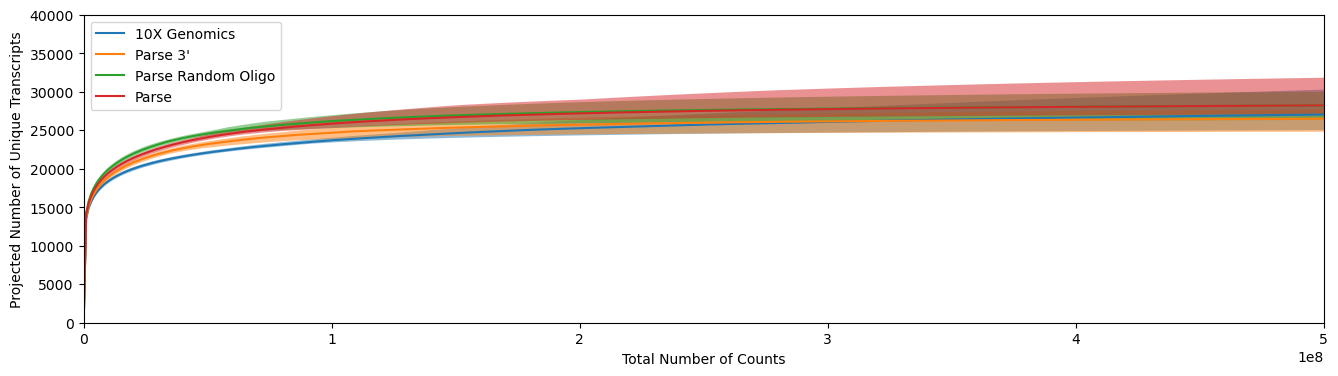

In [13]:
plt.figure(figsize=(16, 4))
for data in raw_datasets:
    pred = data.uns['pred_upsample']
    plt.plot(pred[:, 0], pred[:, 1], label=data.uns['title'])
    plt.fill_between(pred[:, 0], pred[:,2], pred[:,3], alpha=0.5)

plt.legend(loc='upper left')
plt.xlim(0, 5e8)
plt.ylim(0, 4e4)
plt.xlabel('Total Number of Counts')
plt.ylabel('Projected Number of Unique Transcripts')
plt.show()

# Quality Control Comparison

In [11]:
# Scatter plot of genes detected vs. UMI counts
def scatter_reads(ax, data):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ax.scatter(x, y, color="green", alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title'] + " Reads")

# filter based off of UMI threshold (specified by min_counts)
def refilter(raw_data, min_counts):
    data = raw_data.copy()
    sc.pp.filter_cells(data, min_counts=min_counts)
    data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
    data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
    data.obs['n_counts'] = data.X.sum(axis=1).A1
    data.var['percent_counts'] = data.X.sum(axis=0).A1/data.X.sum() * 100

    return data

# Knee plot with threshold axes
def knee_plot(ax, raw_data, cutoff = 20):
    knee = np.sort((np.array(raw_data.X.sum(axis=1))).flatten())[::-1]
    cell_set = np.arange(len(knee))
    num_cells = cell_set[knee > cutoff][::-1][0]

    ax.loglog(knee, cell_set, linewidth=5, color="g")
    ax.axvline(x=cutoff, linewidth=3, color="k")
    ax.axhline(y=num_cells, linewidth=3, color="k")
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")
    ax.set_title(raw_data.uns['title'] + " Knee Plot")

    print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold for {raw_data.uns['title']}")
    data = refilter(raw_data, knee[num_cells])
    
    return data


# Scatter plot for mitochondrial percentage
def mito_scatter(ax, data):
    sc.pl.scatter(data, x='n_counts', y='percent_mito', ax=ax, show=False)
    ax.set_title(data.uns['title'])
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("")

# Generates violin plots of selected cell metadata
def violin_plots(ax_col, data, groups):
    for i, group in enumerate(groups):
        sc.pl.violin(data, group, ax=ax_col[i], stripplot=False, show=False)
        ax_col[i].set_xticks([])

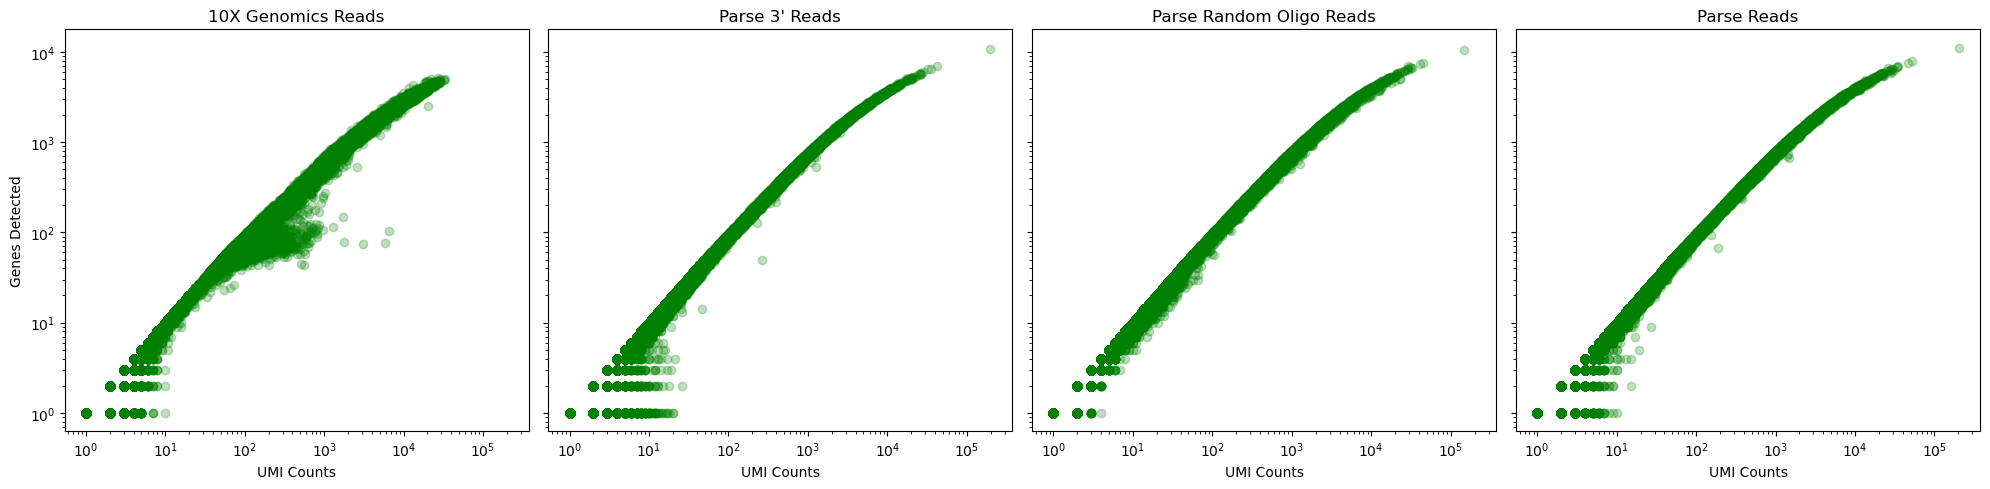

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)

for i, data in enumerate(raw_datasets):
    scatter_reads(ax[i], data)

ax[0].set_ylabel("Genes Detected")

plt.tight_layout()
plt.show()

In [13]:
# Retrieve gene annotations from ensemble
def queryBiotype(dataset):
    # Query Ensembl for biotypes
    type_result = dataset.query(attributes=[
        'external_gene_name',
        'ensembl_gene_id_version',
        'transcript_biotype'])

    # Clean column names
    type_result.columns = ['gene_name', 'gene_id', 'gene_type']

    # From biotypes to bool cols
    type_result['is_lnc'] = (type_result['gene_type'] == 'lncRNA')
    type_result['is_pc'] = (type_result['gene_type'] == 'protein_coding')
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    type_result['is_mito'] = type_result['gene_name'].str.startswith("MT")
    # ribosomal genes
    type_result['is_ribo'] = type_result['gene_name'].str.startswith(("RPS", "RPL"))

    type_result.drop('gene_type', axis=1, inplace=True)
    return type_result

def queryLength(dataset):
    # Query Ensembl for approximate transcript lengths
    length_result = dataset.query(attributes=[
        'external_gene_name',
        'ensembl_gene_id_version', 
        'ensembl_exon_id',
        'exon_chrom_start',
        'exon_chrom_end'])

    # Clean column names
    length_result.columns = ['gene_name','gene_id', 'exon_id', 'exon_start', 'exon_end']
    l_df = length_result.copy()

    # Drop duplicates to avoid counting shared exons multiple times
    l_df.drop_duplicates(subset=['gene_name','gene_id', 'exon_start', 'exon_end'], inplace=True)

    # Compute exon lengths
    l_df['exon_length'] = l_df['exon_end'] - l_df['exon_start'] + 1

    # Sum exon lengths per gene
    gene_lengths = l_df.groupby(['gene_id','gene_name'])['exon_length'].sum().reset_index()
    gene_lengths.rename(columns={'exon_length': 'gene_length'}, inplace=True)

    return gene_lengths

def queryGC(dataset):
    # Query Ensemble for Gene GC Content
    gc_result = dataset.query(attributes=[
    'ensembl_transcript_id_version',
    'external_gene_name',
    'ensembl_gene_id_version',
    'percentage_gene_gc_content'])

    # Clean column names
    gc_result.columns = ['transcript_id', 'gene_name', 'gene_id', 'gc_content']
    # Drop duplicates to avoid counting shared exons multiple times
    gc_result.drop_duplicates(subset=['gene_name','gene_id','transcript_id','gc_content'], inplace=True)
    gc_result.drop('transcript_id', axis=1, inplace=True)

    # average gc_content per trancript
    gc_content = gc_result.groupby(['gene_id','gene_name'])['gc_content'].mean().reset_index()

    return gc_content
    

def queryEnsembl(datasets, path, force = False):
    if os.path.exists(path) and not force:
        gene_info = pd.read_csv(path, index_col = [0])
    else:
        # Connect to server
        server = Server(host='http://ensembl.org')
        dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                        .datasets['mmusculus_gene_ensembl']

        type_result = queryBiotype(dataset)
        length_result = queryLength(dataset)
        gc_result = queryGC(dataset)

        gene_info = pd.merge(length_result, type_result, on=['gene_name','gene_id'])
        gene_info = pd.merge(gene_info, gc_result, on=['gene_name','gene_id'])
            
        gene_info.drop_duplicates(subset = ['gene_name', 'gene_id'], inplace=True)
        gene_info.to_csv(path)
        
    return gene_info

In [14]:
# Path to save gene metadata so don't need to query Ensembl 
# more than once
gene_info_path = "gene_attributes.csv"
gene_info = queryEnsembl(raw_datasets, gene_info_path, force=True) 

In [15]:
# Add cell metrics to anndata object given Ensembl gene metadata
def add_cell_metrics(data, gene_info):
    # retrieve gene metadata
    lnc_result = gene_info["gene_id"][gene_info['is_lnc']].tolist()
    pc_result = gene_info["gene_id"][gene_info['is_pc']].tolist()
    gene_lengths = gene_info[['gene_id', 'gene_length']].drop_duplicates()
    gc_content = gene_info[['gene_id', 'gc_content']].drop_duplicates()

    lncRNA_genes = set(data.var["gene_id"].tolist()).intersection(set(lnc_result))
    pc_genes = set(data.var["gene_id"].tolist()).intersection(set(pc_result))
    
    # Identify lncRNA genes
    data.var["is_lnc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

    # Identify protein-coding genes
    data.var["is_pc"] = np.full(len(data.var_names), False)
    data.var.loc[data.var["gene_id"].isin(list(pc_genes)), ["is_pc"]] = True

    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    data.var["is_mito"] = data.var_names.str.startswith("Mt")
    # ribosomal genes, all caps for human, first-letter capitalized for mouse
    data.var["is_ribo"] = data.var_names.str.startswith(("Rps", "Rps"))

    pc_counts = data[:, data.var['is_pc']].X.sum(axis=1)
    mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
    ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
    lnc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

    # Calculate total counts per cell
    total_counts = data.X.sum(axis=1)

    # Calculate percent mitochondrial and ribosomal gene expression per cell
    data.obs['percent_pc'] = np.array(pc_counts / total_counts * 100).flatten()
    data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
    data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
    data.obs['percent_lnc'] = np.array(lnc_counts / total_counts * 100).flatten()

    # Calculate gene lengths based on exon lengths
    index = data.var.index
    if not 'gene_length' in data.var.columns:
        data.var = data.var.merge(gene_lengths,how='left',on=['gene_id']).fillna(1)
    if not 'gc_content' in data.var.columns:
        data.var = data.var.merge(gc_content,how='left',on=['gene_id']).fillna(0)
    data.var.set_index(index,inplace=True)

In [16]:
for data in raw_datasets:
    add_cell_metrics(data, gene_info)

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/functools.py:909: ImplicitModificationWarning: Tra

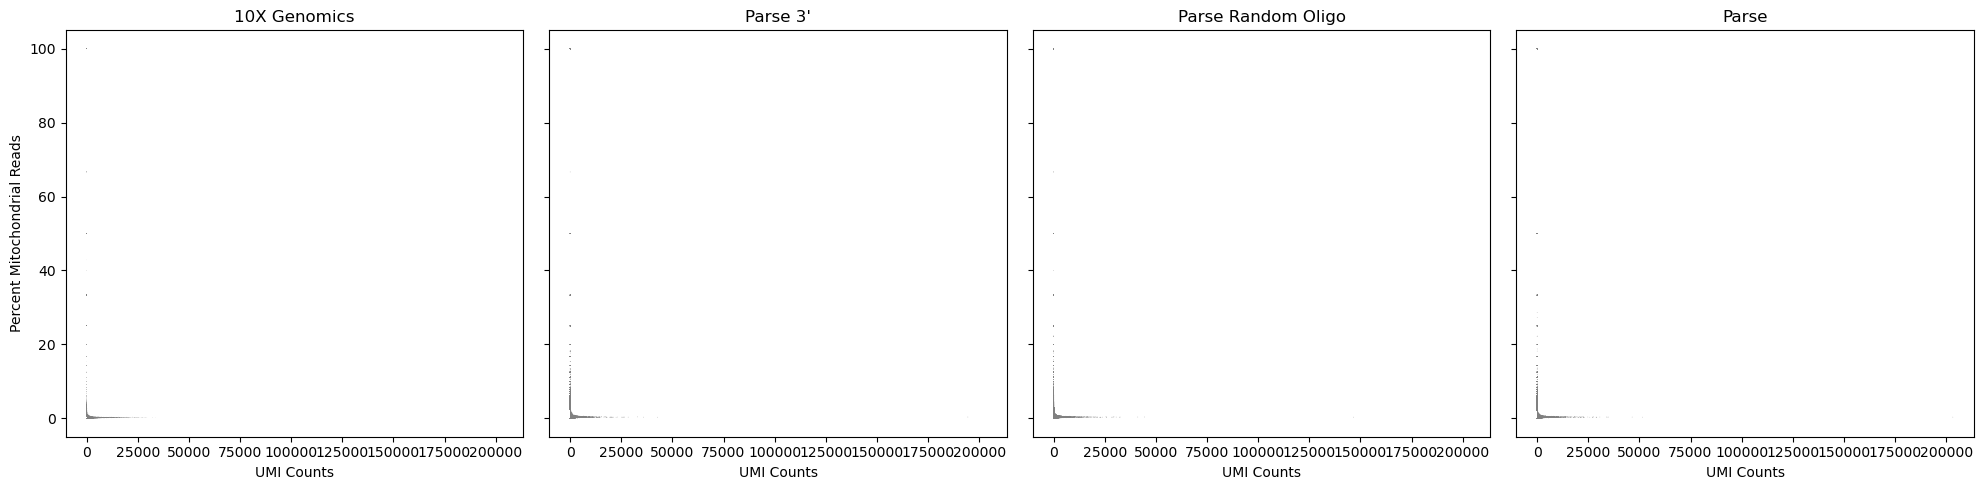

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), sharey=True,sharex=True)
for i, data in enumerate(raw_datasets):
    mito_scatter(ax[i], data)

ax[0].set_ylabel("Percent Mitochondrial Reads")

plt.tight_layout()
plt.show()

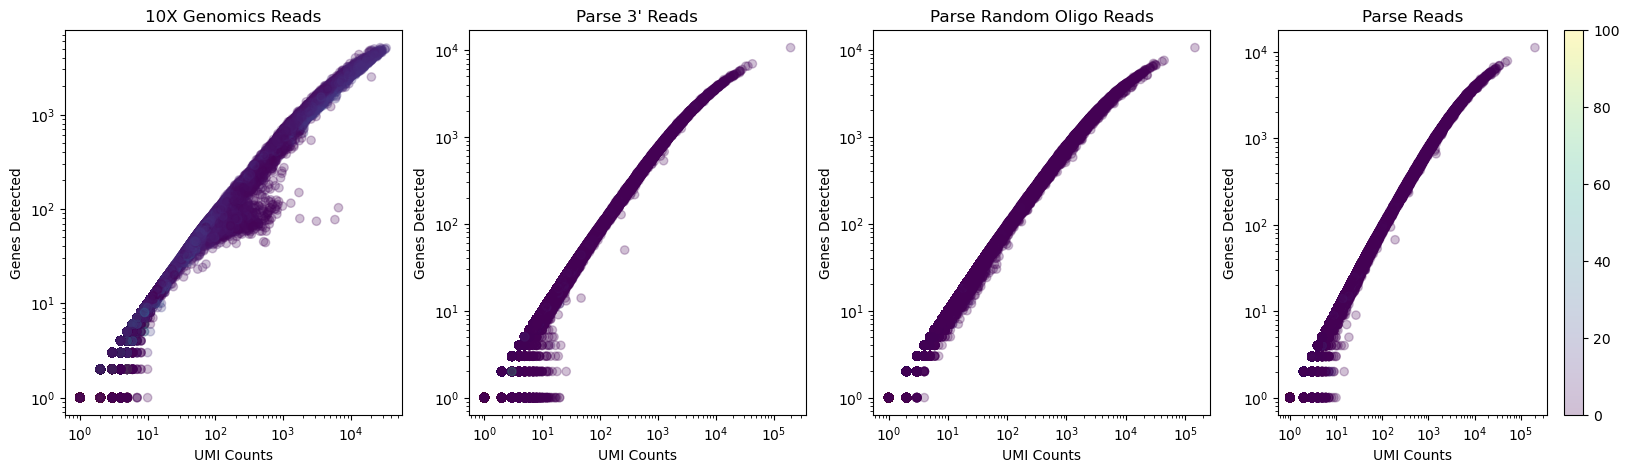

In [18]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, raw_datasets):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    ribo_content = data.obs['percent_ribo'].tolist()

    im = ax.scatter(x, y, c=ribo_content, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

In [19]:
def get_mean_distance(data, ribo_thresh = None, distance = cosine_distances):
    if ribo_thresh:
        data = data[data.obs['percent_ribo'] < ribo_thresh]
    mean_cell = np.asarray(data.X.mean(axis=0))
    dist = distance(data.X, mean_cell)
    return data, dist

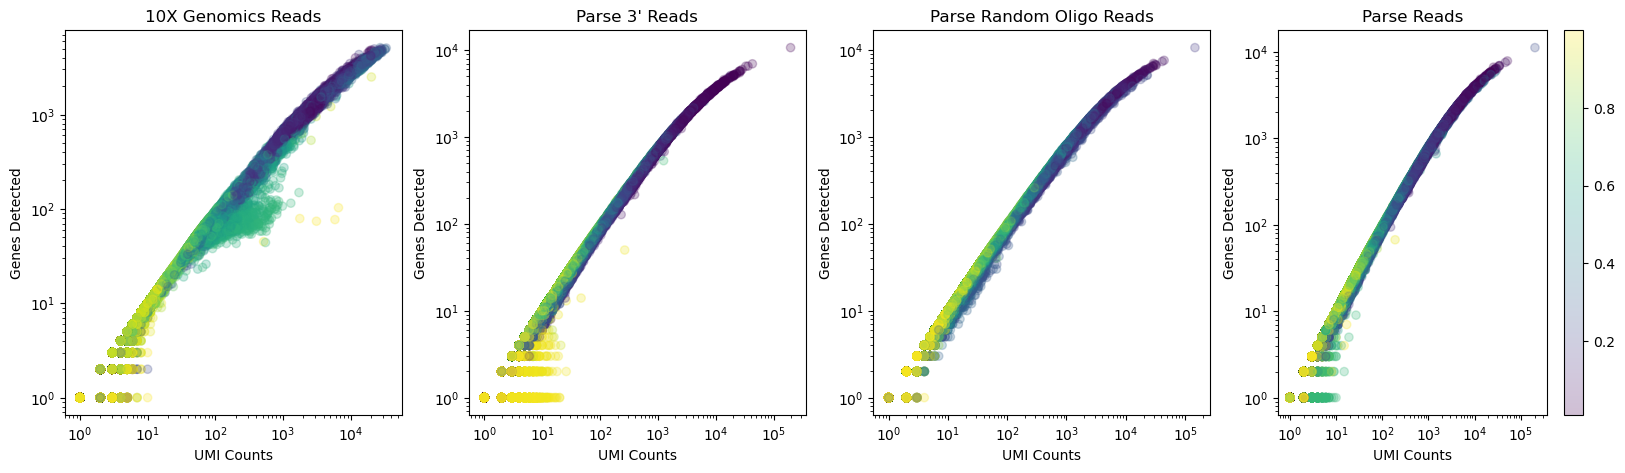

In [20]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, raw_datasets):
    filtered_data, dist = get_mean_distance(data)
    x = np.asarray(filtered_data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(filtered_data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=dist, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

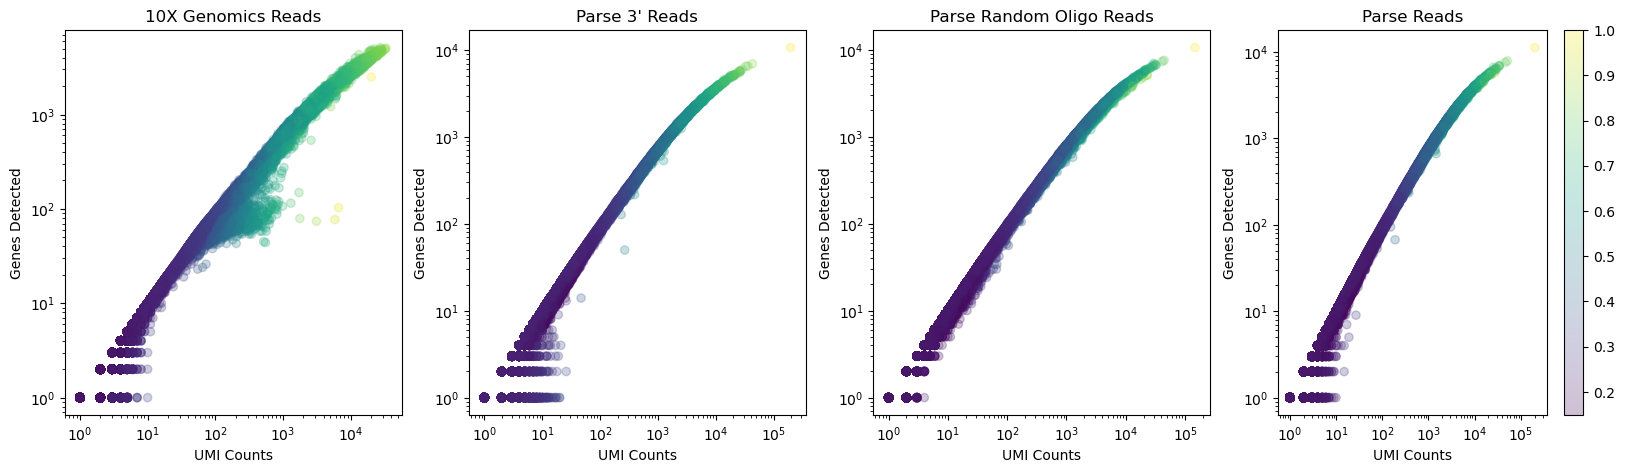

In [21]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, raw_datasets):
    filtered_data, dist = get_mean_distance(data, distance = euclidean_distances)
    dist = np.log(dist) / np.max(np.log(dist))
    x = np.asarray(filtered_data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(filtered_data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=dist, cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

13,270 cells passed the 301 UMI threshold for 10X Genomics
13,275 cells passed the 301 UMI threshold for Parse 3'
13,270 cells passed the 271 UMI threshold for Parse Random Oligo
13,282 cells passed the 349 UMI threshold for Parse


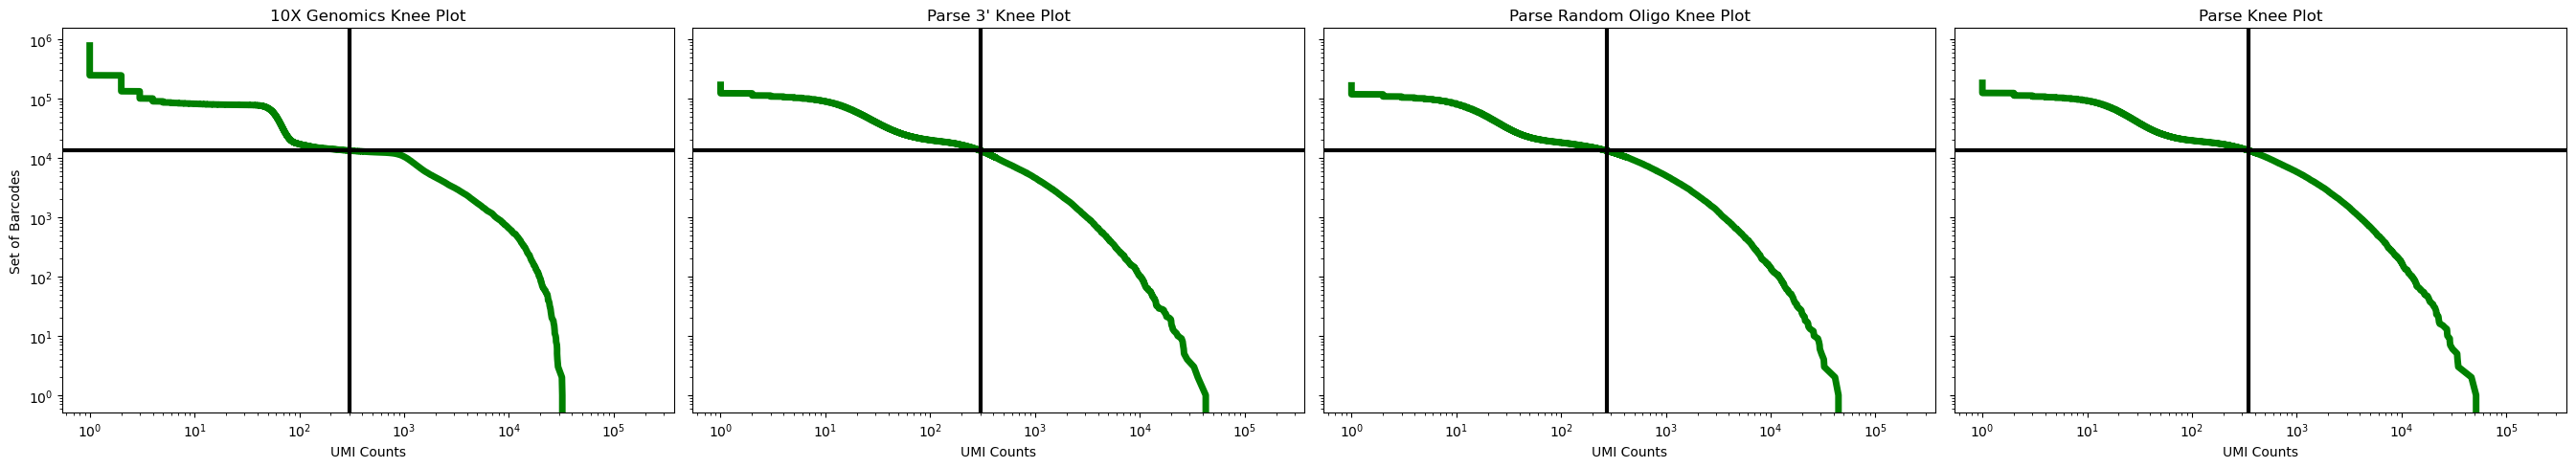

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(27,5), sharey=True,sharex=True)

cutoffs = [301, 301, 271, 349]

datasets = []
for i, (data, cutoff) in enumerate(zip(raw_datasets, cutoffs)):
    datasets.append(knee_plot(ax[i], data, cutoff=cutoff))

ax[0].set_ylabel("Set of Barcodes")

plt.tight_layout()
plt.show()

In [23]:
def updateGeneInfo(gene_info, datasets, path):
    for data in datasets:
        gene_info = gene_info.merge(data.var[['gene_id','n_cells','percent_counts']], on = ['gene_id'], how = 'left')
        gene_info.rename(columns={'n_cells':data.uns['name']+'_n_cells', 
                                'percent_counts':data.uns['name']+'_percent_counts'}, 
                                inplace=True)
    gene_info = gene_info.dropna(subset = ['10x_n_cells', 'polyT_n_cells', 'randO_n_cells', 'parse_n_cells'], how = 'all')
    gene_info = gene_info.fillna(0)
    gene_info.to_csv(path)
    return gene_info

full_gene_info_path = 'gene_comparisons.csv'
gene_info = updateGeneInfo(gene_info, datasets, full_gene_info_path)

/tmp/ipykernel_4009661/1246611898.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gene_info = gene_info.fillna(0)


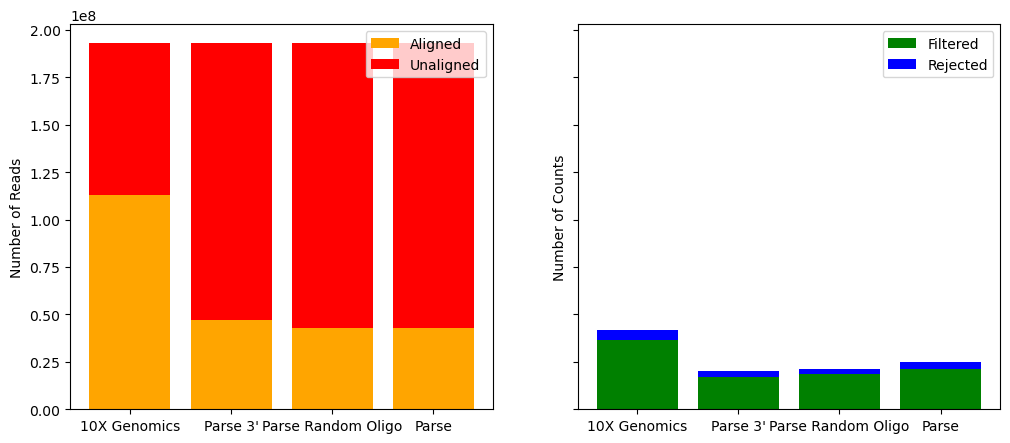

In [24]:
fig, axs = plt.subplots(1,2, figsize = (12,5), sharey=True)

processed = np.array([data.uns['n_processed'] for data in datasets])
aligned = np.array([data.uns['n_aligned'] for data in datasets])
counts = np.array([data.uns['n_raw_counts'] for data in datasets])
filtered_counts = np.array([data.X.sum() for data in datasets])
labels = [data.uns['title'] for data in datasets]

unaligned = processed - aligned
rejected_counts = counts - filtered_counts

axs[0].bar(labels, aligned, label = "Aligned", color = "orange")
axs[0].bar(labels, unaligned, bottom=aligned, label = "Unaligned", color = "red")
axs[0].set_ylabel('Number of Reads')
axs[0].legend()

axs[1].bar(labels, filtered_counts, label = "Filtered", color = 'green')
axs[1].bar(labels, rejected_counts, bottom = filtered_counts, label = "Rejected", color = "blue")
axs[1].set_ylabel('Number of Counts')
axs[1].legend()

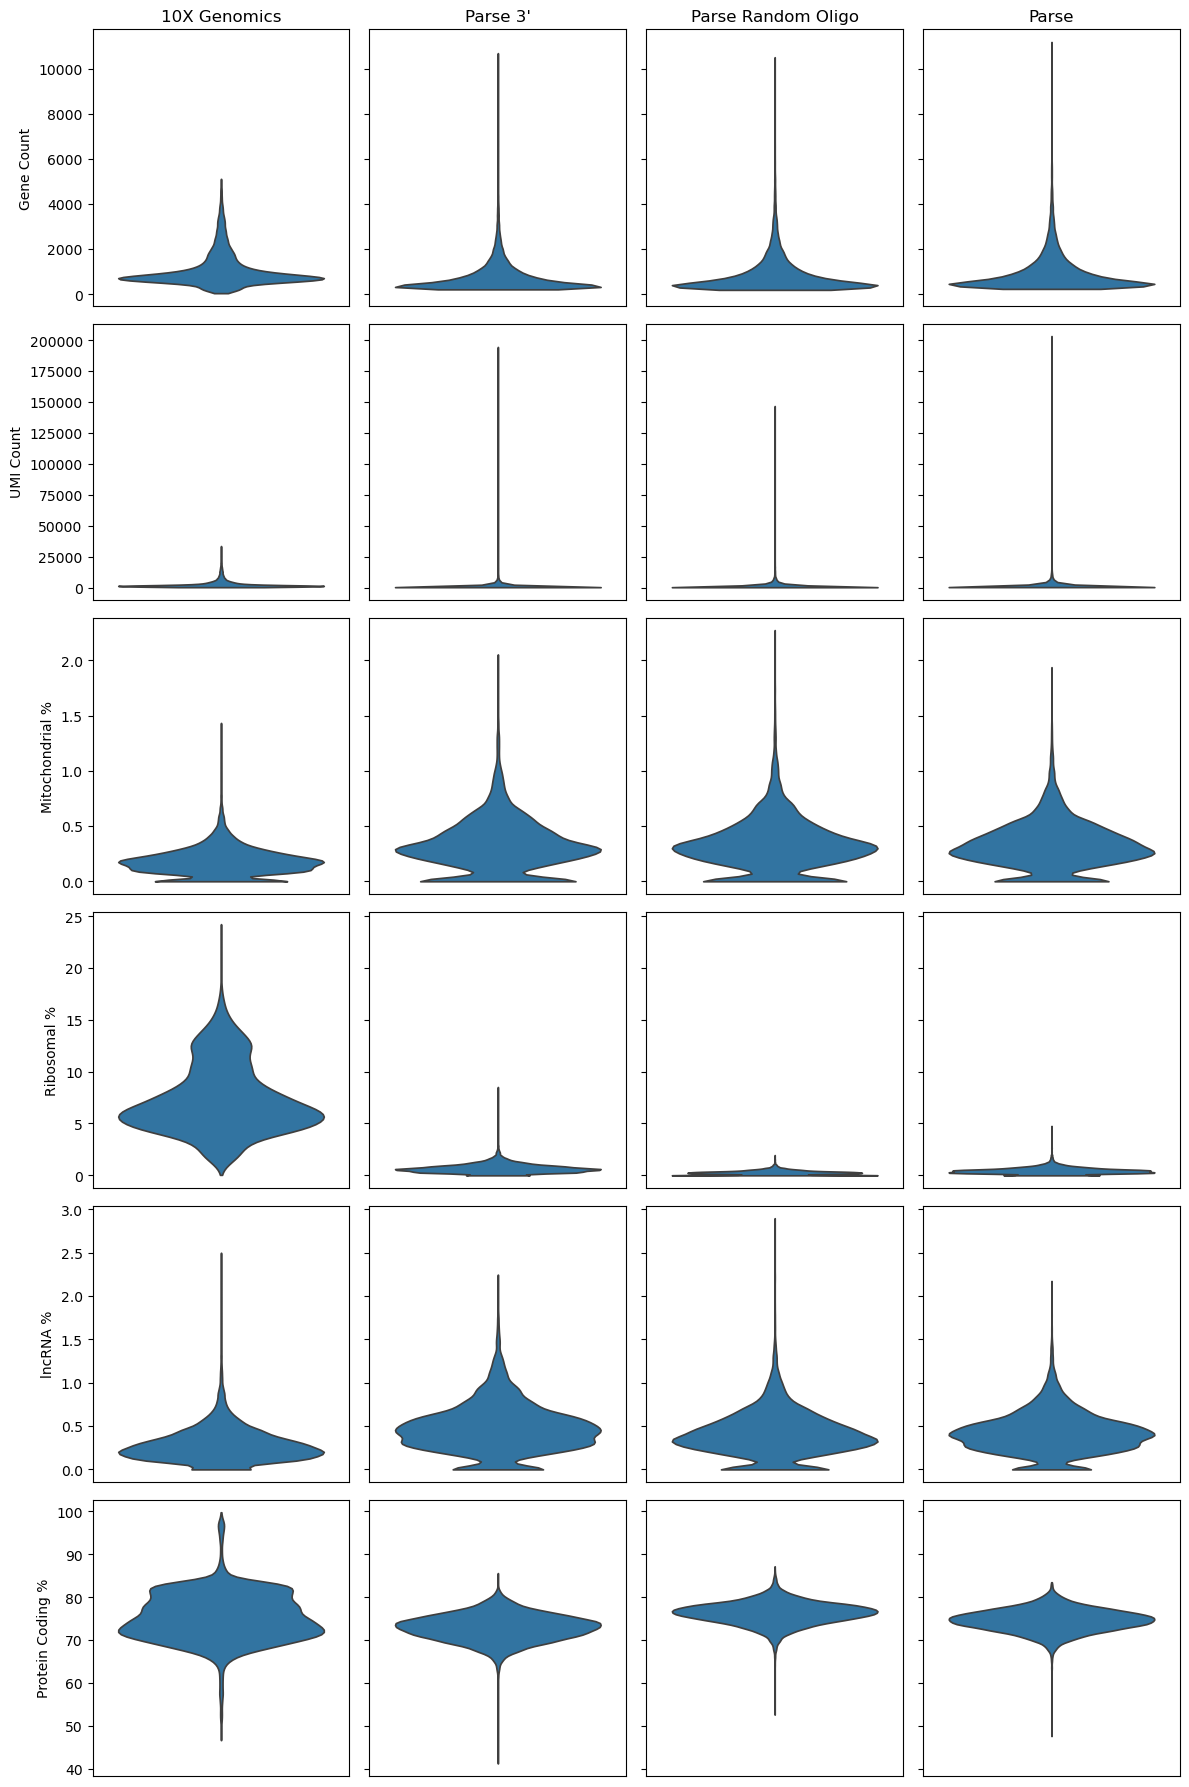

In [25]:
groups = ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc', 'percent_pc']
group_names = ['Gene Count', 'UMI Count', 'Mitochondrial %', 'Ribosomal %', 'lncRNA %', 'Protein Coding %']

fig, ax = plt.subplots(len(groups), 4, figsize=(12,18), sharey='row')
for i, data in enumerate(datasets):
    violin_plots(ax[:, i], data, groups)

for i, group in enumerate(group_names):
    ax[i,0].set_ylabel(group)

for i, data in enumerate(datasets):
    ax[0,i].set_title(data.uns['title'])

plt.tight_layout()
plt.show()

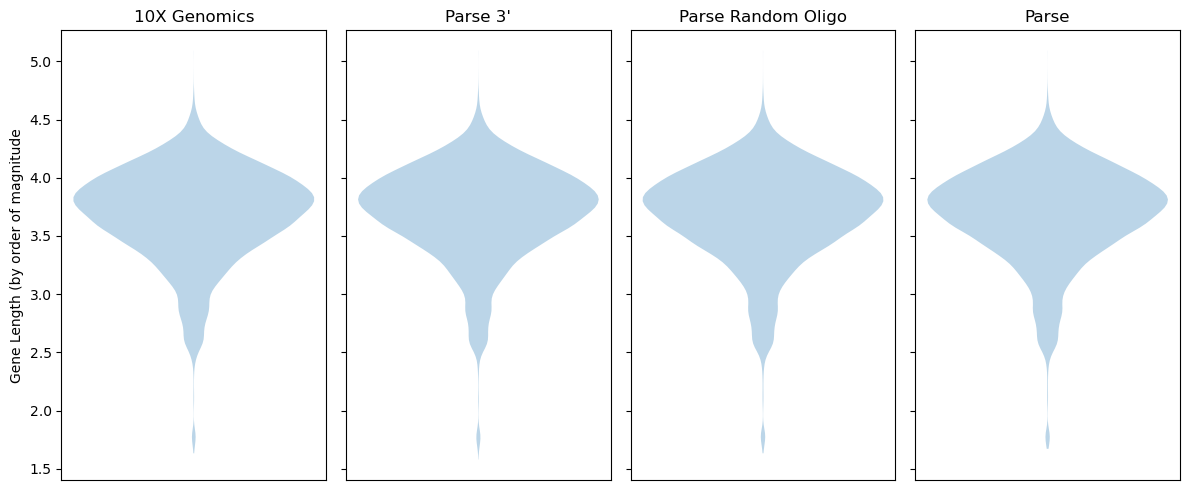

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    lengths = data.var['gene_length'][data.var['gene_length']>1]
    ax[i].violinplot(np.log10(lengths),showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Gene Length (by order of magnitude')


plt.tight_layout()
plt.show()

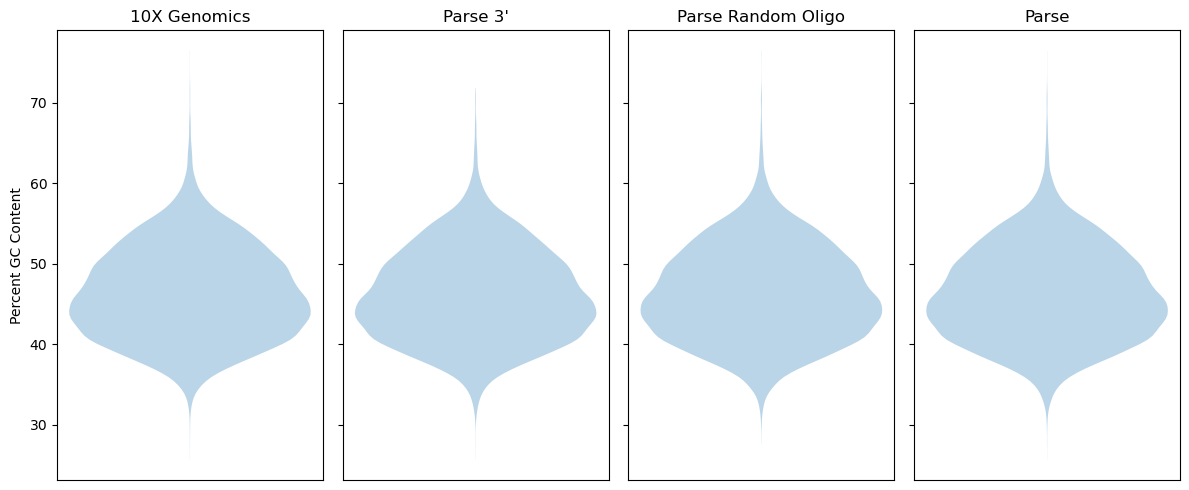

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(12,5), sharey='row')
for i, data in enumerate(datasets):
    gcs = data.var.loc[data.var['gc_content']>0,'gc_content']
    ax[i].violinplot(gcs,showextrema=False)
    ax[i].set_title(data.uns['title'])
    ax[i].set_xticks([])

ax[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

# Doublet Detection Comparison

In [28]:
# Detect doublets Scrublet (by sample is optional)
def doublet_detection(data):
    scrub = scr.Scrublet(data.X, random_state = 42)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    data.obs['doublet_score'] = doublet_scores
    data.obs['predicted_doublet'] = predicted_doublets
    return data, scrub

scrubs = []
for data in datasets:
    data, scrub = doublet_detection(data)
    scrubs.append(scrub)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 18.9%
Elapsed time: 19.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 18.2%
Estimated detectable doublet fraction = 35.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 51.4%
Elapsed time: 15.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 31.2%
Estimated detectable doublet fraction = 58.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 53.0%
Elapsed time: 19.9 seconds
Preprocessing...
Simulating

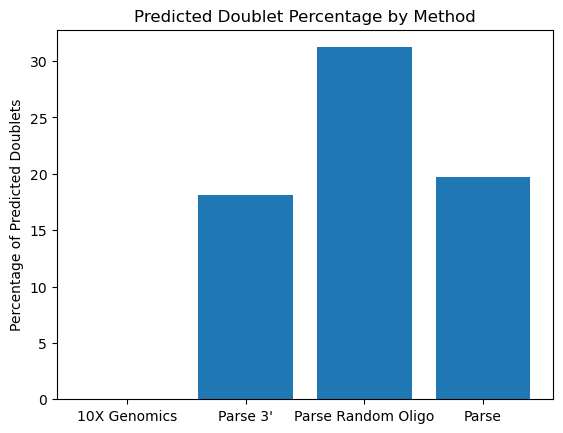

In [29]:
bottom = np.zeros(len(datasets))
titles = [data.uns['title'] for data in datasets]
percent_doublets = [data.obs['predicted_doublet'].sum()/len(data.obs)*100 for data in datasets]

plt.bar(titles, percent_doublets)
plt.ylabel('Percentage of Predicted Doublets')
plt.title('Predicted Doublet Percentage by Method')

plt.show()

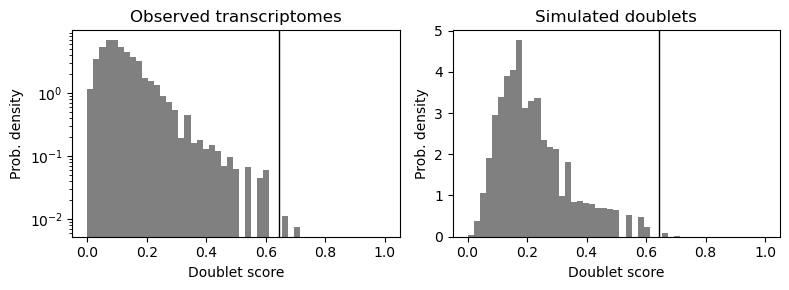

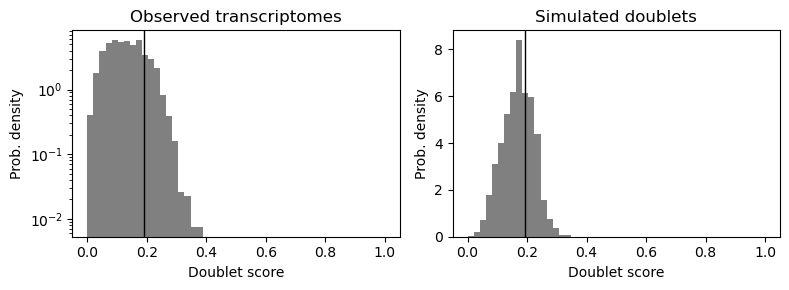

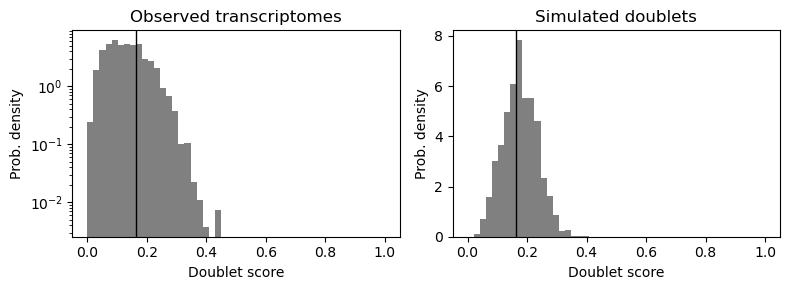

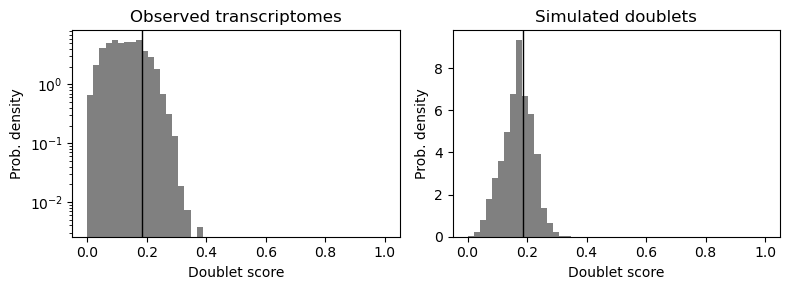

In [30]:
# Should see two peaks separated by threshold
for scrub in scrubs:
    scrub.plot_histogram()

/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mcaskey/miniconda3/envs/10XvParse/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


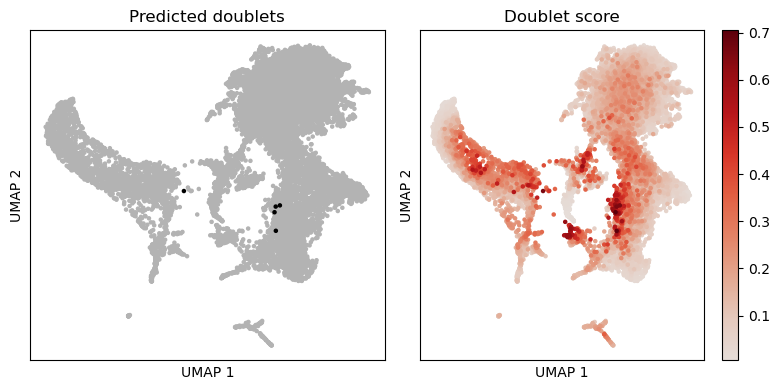

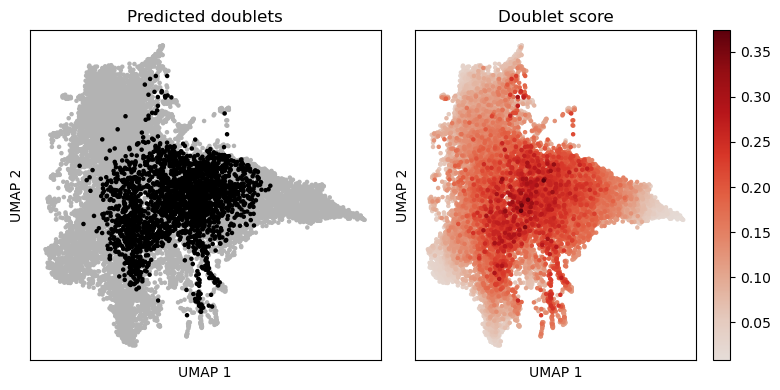

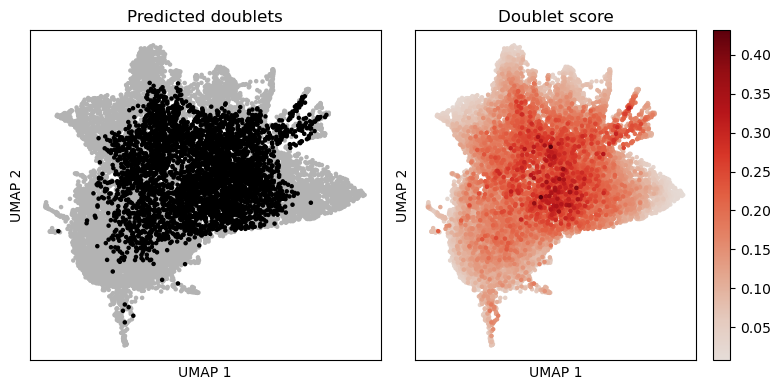

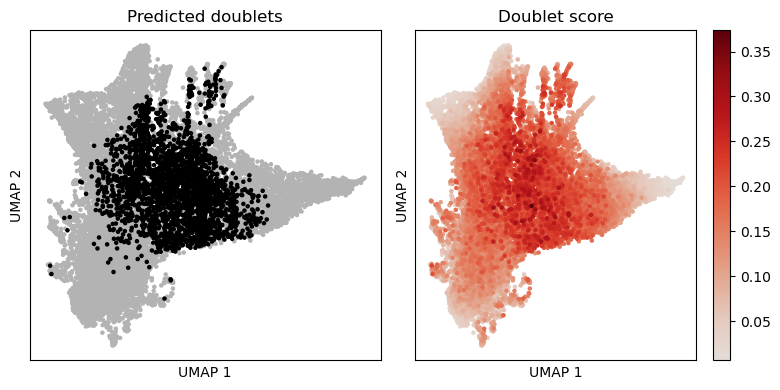

In [31]:
# Should see clustering of doublets
for scrub in scrubs:
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3)) 
    scrub.plot_embedding('UMAP', order_points=True)

# Read/Gene Comparisons

In [32]:
T_marker_names = ['Cd3d', 'Cd3g', 'Cd4', 'Cd8a',
                'Il2ra', 'Themis', 'Cd28', 'Foxp3',
                'Cd3e']
T_receptor_names = ['Trbv','Trav', 'Trgv', 'Trdv']
T_markers = ['ENSMUSG00000032094.9', 'ENSMUSG00000002033.15', 'ENSMUSG00000023274.15', 'ENSMUSG00000053977.14',
           'ENSMUSG00000026770.6', 'ENSMUSG00000049109.16', 'ENSMUSG00000026012.3', 'ENSMUSG00000039521.14',
           'ENSMUSG00000032093.8']
T_marker_types = ['Pan T cells', 'Pan T cells', 'Helper T cells', 'Cytotoxic T cells',
                'Regulatory T cells', 'Thymocyte Selection', 'Naive T cells',
                'Pan T cells']
T_marker_protein = ['receptor', 'receptor', 'receptor', 'receptor',
                  'receptor', 'regulator', 'receptor', 'transcription factor',
                  'receptor']

# Indicative of epithelial cells
cytokeratin_names = ['Krt']

In [33]:
# Displays violin plots of the distributions of 
# of the specified marker genes by cell
def marker_genes(ax, data, markers):
    gene_dist = []
    for gene in markers:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(markers) + 1), markers)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Thymus Marker Genes")

# Displays violin plots of the distributions of 
# of the specified marker genes by cell. Specific to
# similar sets of genes for which it is not important
# to differentiate between so counts can be collapsed
def collapsed_marker_genes(ax, data, marker_prefixes):
    genes = data.var

    gene_dist = []
    for prefix in marker_prefixes:
        mask = genes[genes.index.str.startswith(prefix)].index
        gene_dist.append(np.nan_to_num(data[:,mask].X.toarray().sum(axis=1).transpose() / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(marker_prefixes) + 1), marker_prefixes)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Thymus Marker Genes")

# Displays violin plots of the distributions of the top 10 expressed gene/transcripts
# (by number of cells expressed in) by cell
def top_gene_cell_expression(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")

    ax.set_title(data.uns['title'] + " Top 10 Genes by Cell Expression")

# Displays violin plots of the distributions of the top 10 (by total counts) expressed 
# gene/transcripts by cell
def top_gene_counts(ax, data):
    genes = data.var
    top_genes = genes.sort_values(by='percent_counts',ascending=False).head(10).index

    gene_dist = []
    for gene in top_genes:
        gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

    ax.violinplot(gene_dist, showmeans=True)
    ax.set_xticks(np.arange(1, len(top_genes) + 1), top_genes)
    ax.set_ylabel("")
    ax.set_title(data.uns['title'] + " Top 10 Genes by Total Counts")

# Compares the gene count percentatages between two methods
def compare_genes(data_x, data_y):
    x_var = data_x.var.reset_index(names='gene_name')
    x_var.drop('n_cells', axis=1,inplace=True)

    y_var = data_y.var.reset_index(names='gene_name')
    y_var.drop('n_cells',axis=1,inplace=True)

    shared_data = pd.merge(x_var, y_var, on=['gene_name','gene_id','gene_length', 'gc_content'], how='outer')
    shared_data.fillna(0,inplace=True)

    for col in ['is_lnc','is_mito','is_ribo','is_pc']:
        shared_data[col] = shared_data[col+"_x"] | shared_data[col+"_y"]
        shared_data.drop(col+"_x",axis=1,inplace=True)
        shared_data.drop(col+"_y",axis=1,inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data['percent_counts_y'], shared_data['percent_counts_x']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0] + 1e-10  # add small value to avoid log(0) issues

    #calculate point density
    xy = np.vstack([shared_data['percent_counts_x'].to_numpy().flatten(), shared_data['percent_counts_y'].to_numpy().flatten()])
    shared_data['point_density'] = gaussian_kde(xy)(xy)

    return shared_data

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def scatter_genes(ax, shared_data, data_x, data_y, c_column,  xlim = None, ylim = None, norm = None):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    plot = ax.scatter(x_percent, 
                y_percent, 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data[c_column], 
                cmap='viridis')
    
    ax.set_xlabel(data_x.uns['title'] + ' Gene Percent Count')
    ax.set_ylabel(data_y.uns['title'] + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

# From the output of compare_genes, generates a scatter plot of the gene counts percentages 
# with each method on an axis
def cat_scatter_genes(ax, shared_data, data_x, data_y, color, label=None, xlim = None, ylim = None):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    plot = ax.scatter(x_percent, 
                y_percent, 
                s=50,
                alpha=0.5, 
                c=color,
                label=label)
    
    ax.set_xlabel(data_x.uns['title'] + ' Gene Percent Count')
    ax.set_ylabel(data_y.uns['title'] + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    return plot

# Displays correlation of percent counts from the output of compare_genes on the plot 
# given by ax
def show_correlation(ax, shared_data):
    x_percent = shared_data['percent_counts_x']
    y_percent = shared_data['percent_counts_y']

    # Calculate correlation
    pearson_r = pearsonr(x_percent, y_percent).correlation
    spearman_r = spearmanr(x_percent, y_percent).correlation
    
    x_mean = x_percent.mean()
    y_mean = y_percent.mean()
    x_std = x_percent.std()
    y_std = y_percent.std()
    CCC_r = 2 * pearson_r * x_std * y_std / (x_std**2 + y_std**2 + (x_mean - y_mean)**2)    

    ax.plot([0, 100], [0, 100], color='black', linestyle='--', linewidth=1.5)  # y=x line

    # Add plot annotations
    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, ),
    r'$\rho_C=%.2f$' % (CCC_r, ),))
    ax.text(0.05, 0.85, textstr, transform = ax.transAxes, fontsize = 12)

    return

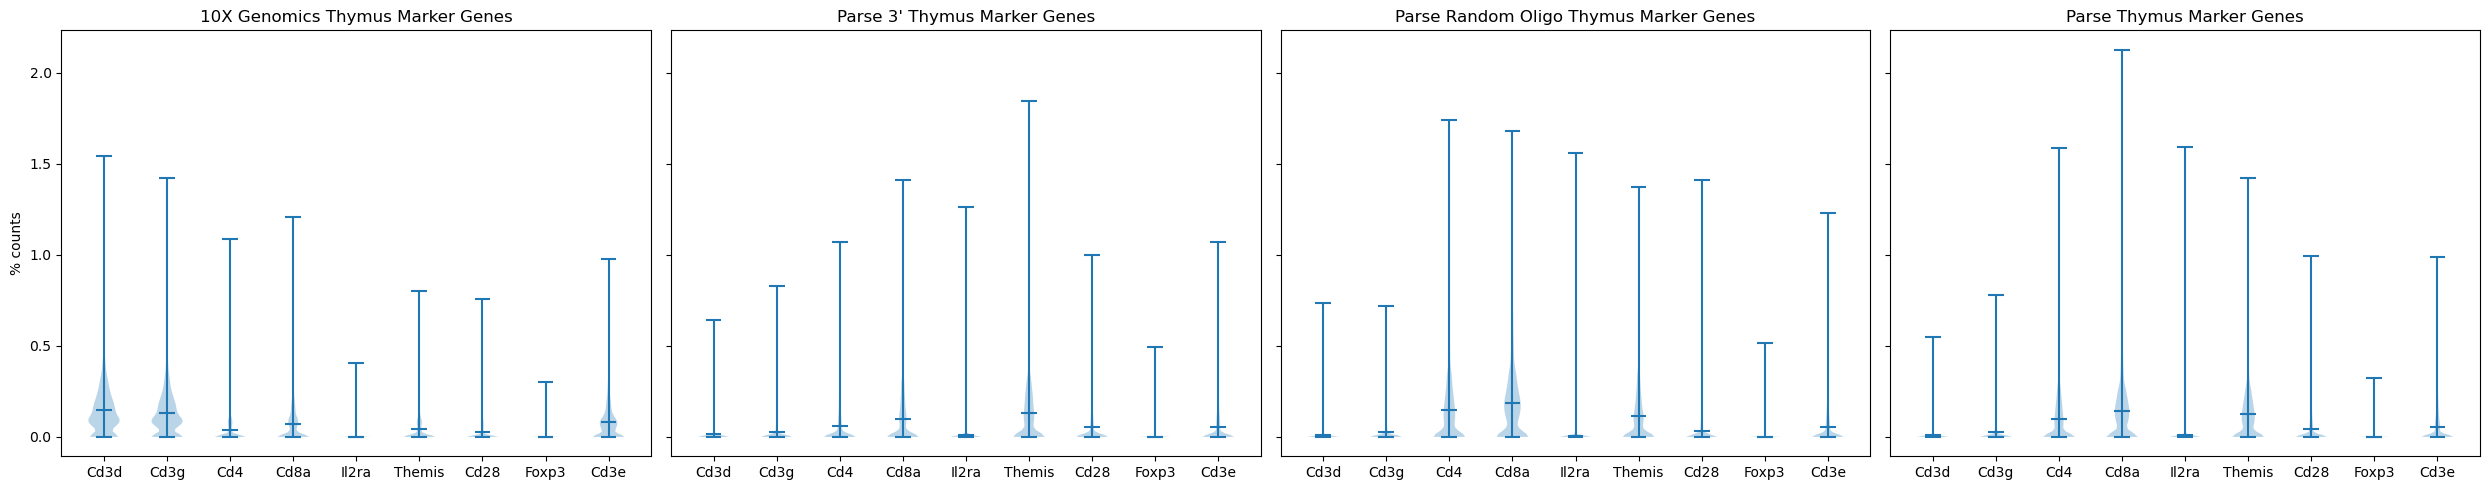

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    marker_genes(ax[i], data, T_marker_names)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

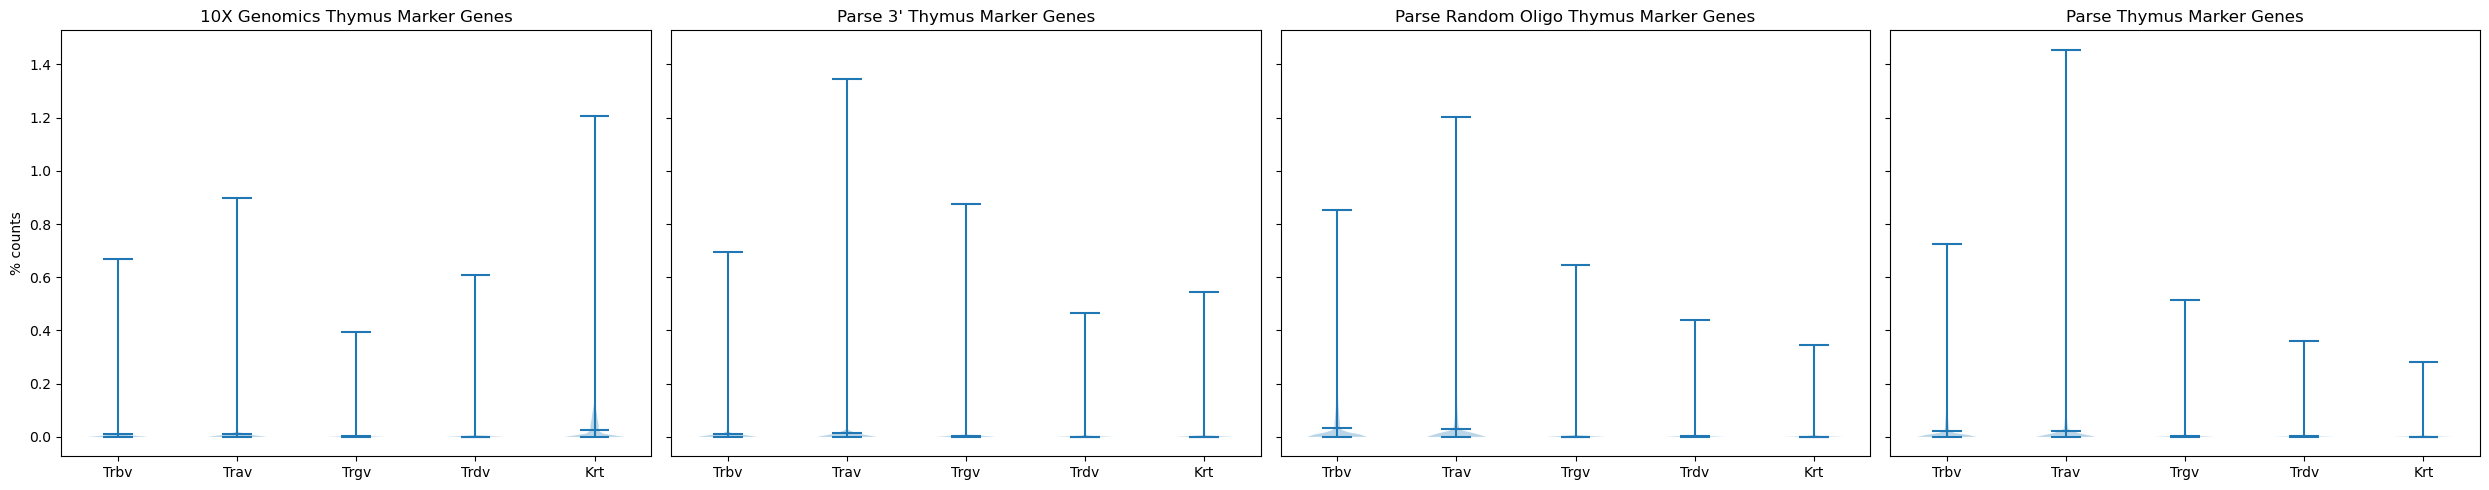

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    collapsed_marker_genes(ax[i], data, T_receptor_names + cytokeratin_names)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

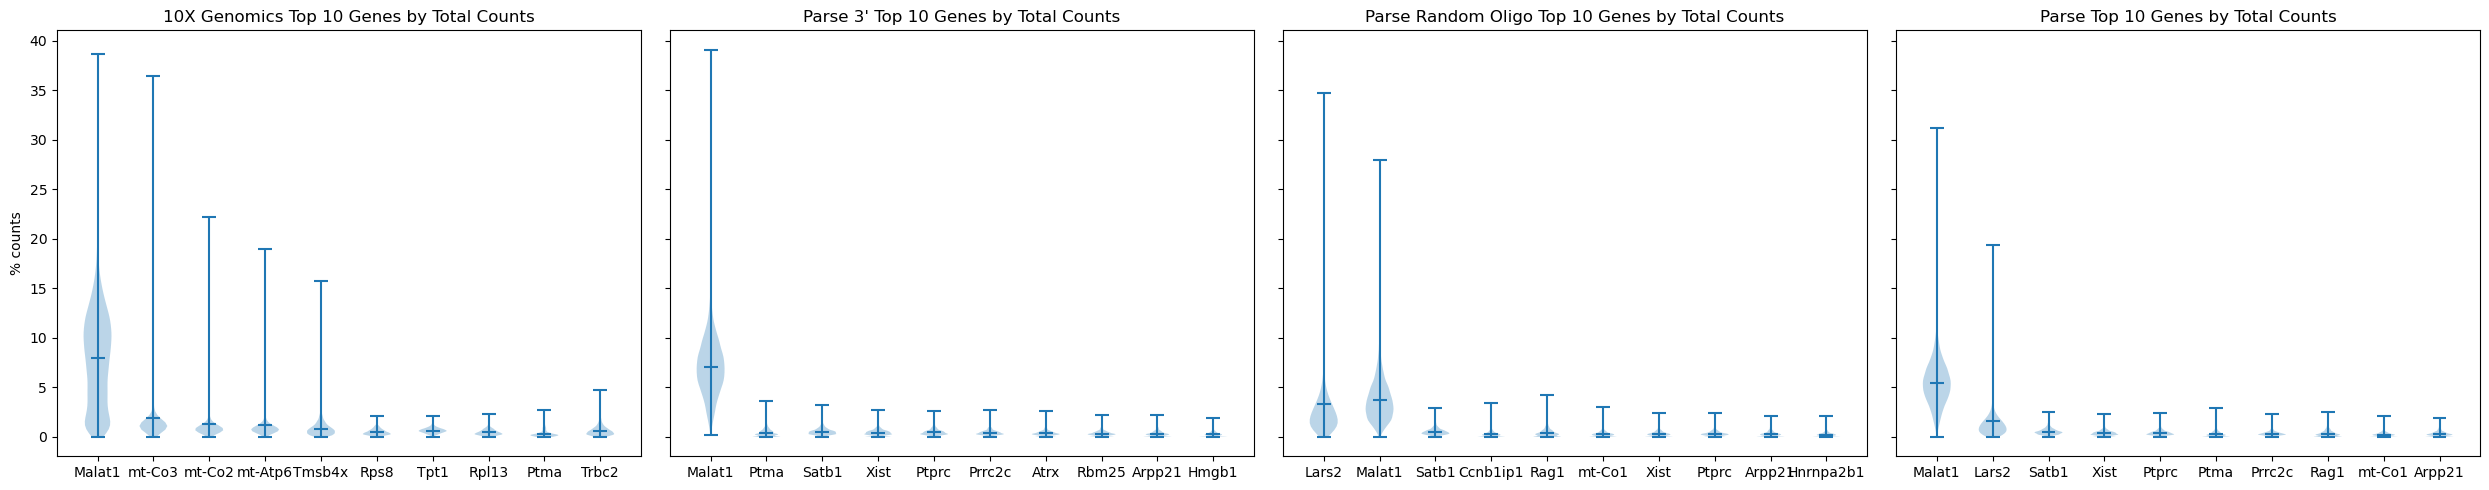

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)

for i, data in enumerate(datasets):
    top_gene_counts(ax[i], data)

ax[0].set_ylabel("% counts")

plt.tight_layout()
plt.show()

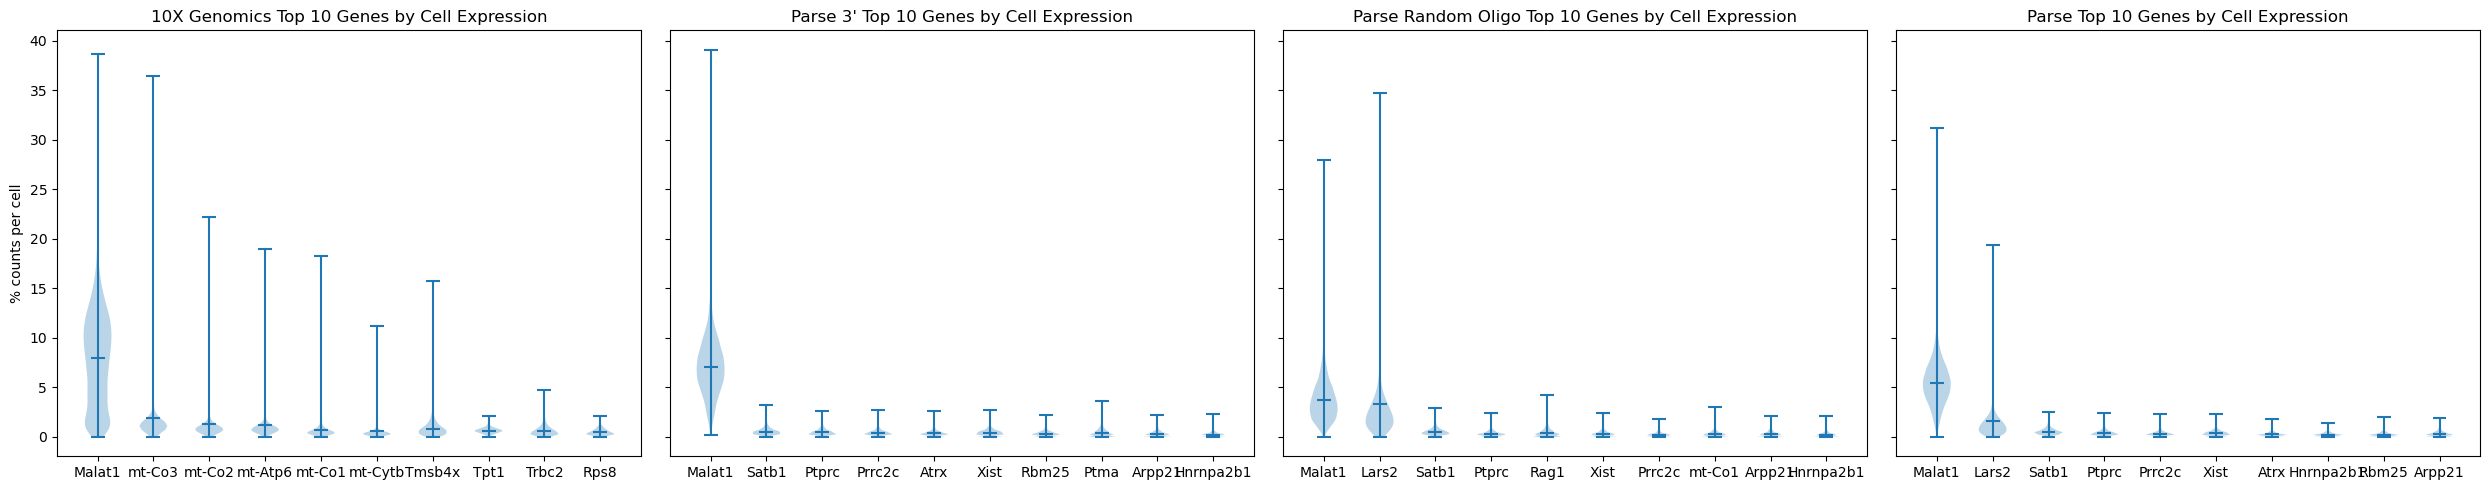

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(25,5), sharey=True)
for i, data in enumerate(datasets):
    top_gene_cell_expression(ax[i], data)

ax[0].set_ylabel("% counts per cell")

plt.tight_layout()
plt.show()

In [38]:
# Plot a scatter plot of comparing gene percent counts between methods given 
# some metric with which to color the plot
def comparisonPlotter(compare_dfs, comparisons, norm, lim, metric, metric_name):
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    for ax, df , pair in zip(axs, compare_dfs,comparisons):
        plot = scatter_genes(ax, 
                            df, 
                            pair[0],
                            pair[1], 
                            metric, 
                            xlim=lim, 
                            ylim=lim, 
                            norm=norm)
        show_correlation(ax,df)

    fig.colorbar(plot, label = metric_name)

    plt.tight_layout()
    plt.show()

# Compare gene percent counts between methods and 
# color by density
def compareByDensity(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['point_density'].tolist())
    norm = LogNorm(min(c_values), max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'point_density',
                      'Density')

# Compare gene percent counts between methods and 
# color by Cook's Distance
def compareByCooks(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['cooks_distance'].tolist())
    norm = LogNorm(min(c_values), max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'cooks_distance',
                      "Cook's Distance")
    
# Compare gene percent counts between methods and 
# color by gene length
def compareByLength(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        df['gene_length'] = df['gene_length']+1
        c_values.extend(df['gene_length'].tolist())
    norm = LogNorm(1, max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'gene_length',
                      'Gene Length')

# Compare gene percent counts between methods and 
# color by GC content
def compareByGC(compare_dfs, comparisons, lim):
    c_values = []
    for df in compare_dfs:
        c_values.extend(df['gc_content'].tolist())
    norm = Normalize(0, max(c_values))

    comparisonPlotter(compare_dfs,
                      comparisons,
                      norm,
                      lim,
                      'gc_content',
                      'Percent GC Content')

# Compare gene percent counts between methods and 
# color by biotype
def compareByType(compare_dfs, comparisons, lim):
    fig, axs = plt.subplots(1, 4, figsize = (25, 5))

    for ax, df , pair in zip(axs, compare_dfs,comparisons):
        cat_scatter_genes(ax, df[~(df['is_mito'] | df['is_ribo'] | df['is_lnc'])], 
                        pair[0], pair[1],'black', 
                        label = 'unspecified non-coding', xlim=lim, ylim=lim)
        for col, c, label in zip(['is_pc', 'is_mito','is_ribo','is_lnc'],
                                ['yellow', 'blue', 'red', 'green'],
                                ['protein coding', 'mtRNA', 'rRNA', 'lncRNA']):
            cat_scatter_genes(ax, df[df[col]], pair[0], pair[1], 
                            c, label=label,xlim=lim, ylim=lim)

        show_correlation(ax,df)
        
    axs[0].legend()

    plt.tight_layout()
    plt.show()

# Generate scatter plots to 
# (1) PolyT vs. RandO (2) 10X vs. PolyT 
# (3) 10X vs. RandO (3) 10X vs. Parse
# compare data in the range specified by lim
def compare(datasets, lim):
    data_10x = datasets[0][:,datasets[0].var['percent_counts'] < lim]
    data_polyT = datasets[1][:,datasets[1].var['percent_counts'] < lim]
    data_randO = datasets[2][:,datasets[2].var['percent_counts'] < lim]
    data_parse = datasets[3][:,datasets[3].var['percent_counts'] < lim]

    comparisons = [(data_polyT,data_randO),
                (data_10x,data_polyT),
                (data_10x,data_randO),
                (data_10x,data_parse)]
    compare_names = ['polyT_randO',
                    '10x_polyT',
                    '10x_randO',
                    '10x_parse']

    compare_dfs = []
    for pair in comparisons:
        compare_dfs.append(compare_genes(pair[0],pair[1]))
    
    compareByDensity(compare_dfs, comparisons, lim)
    compareByCooks(compare_dfs, comparisons, lim)
    compareByLength(compare_dfs, comparisons, lim)
    compareByGC(compare_dfs, comparisons, lim)
    compareByType(compare_dfs, comparisons, lim)

    return compare_names, compare_dfs

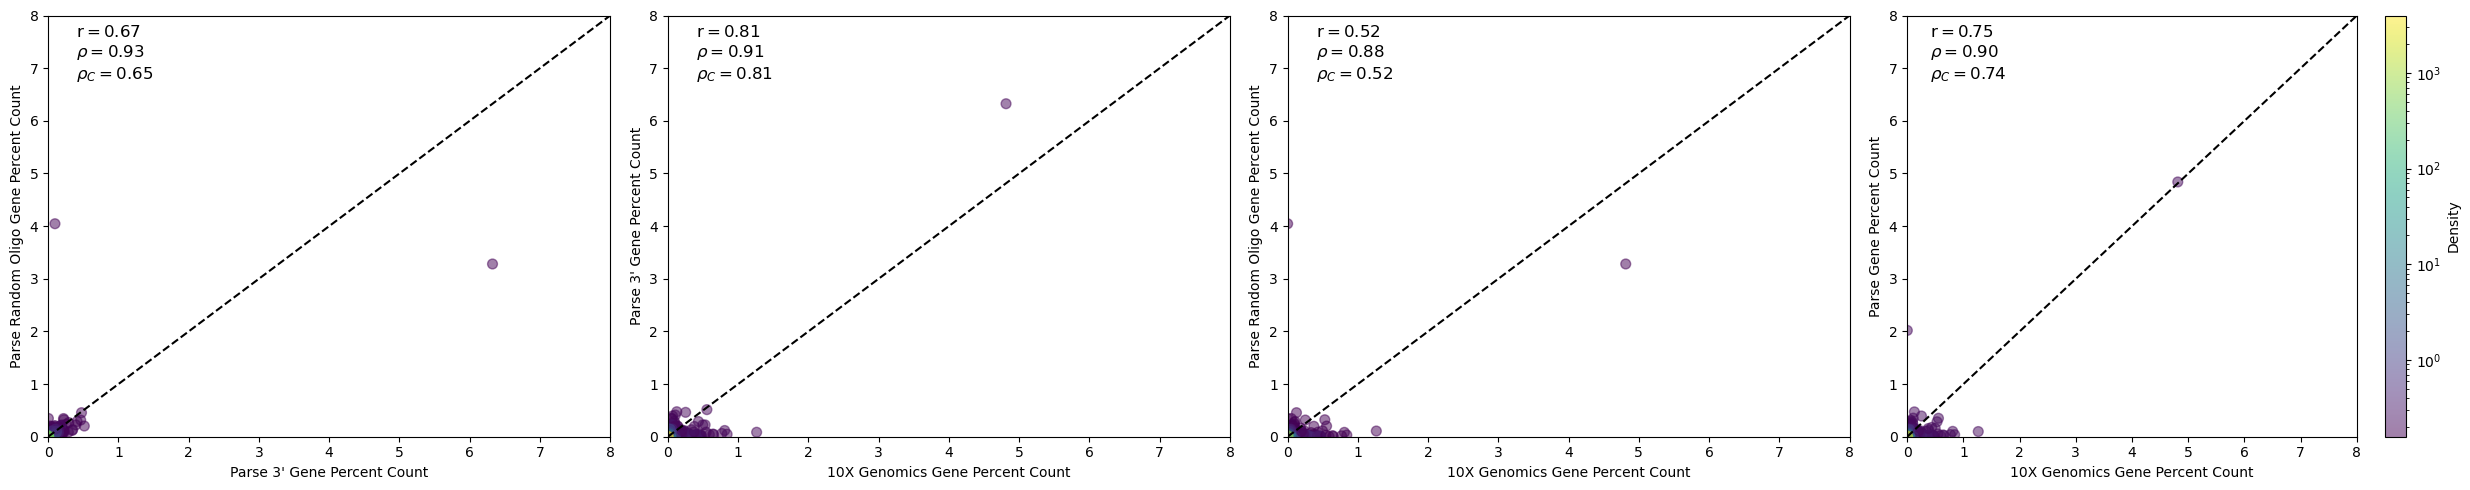

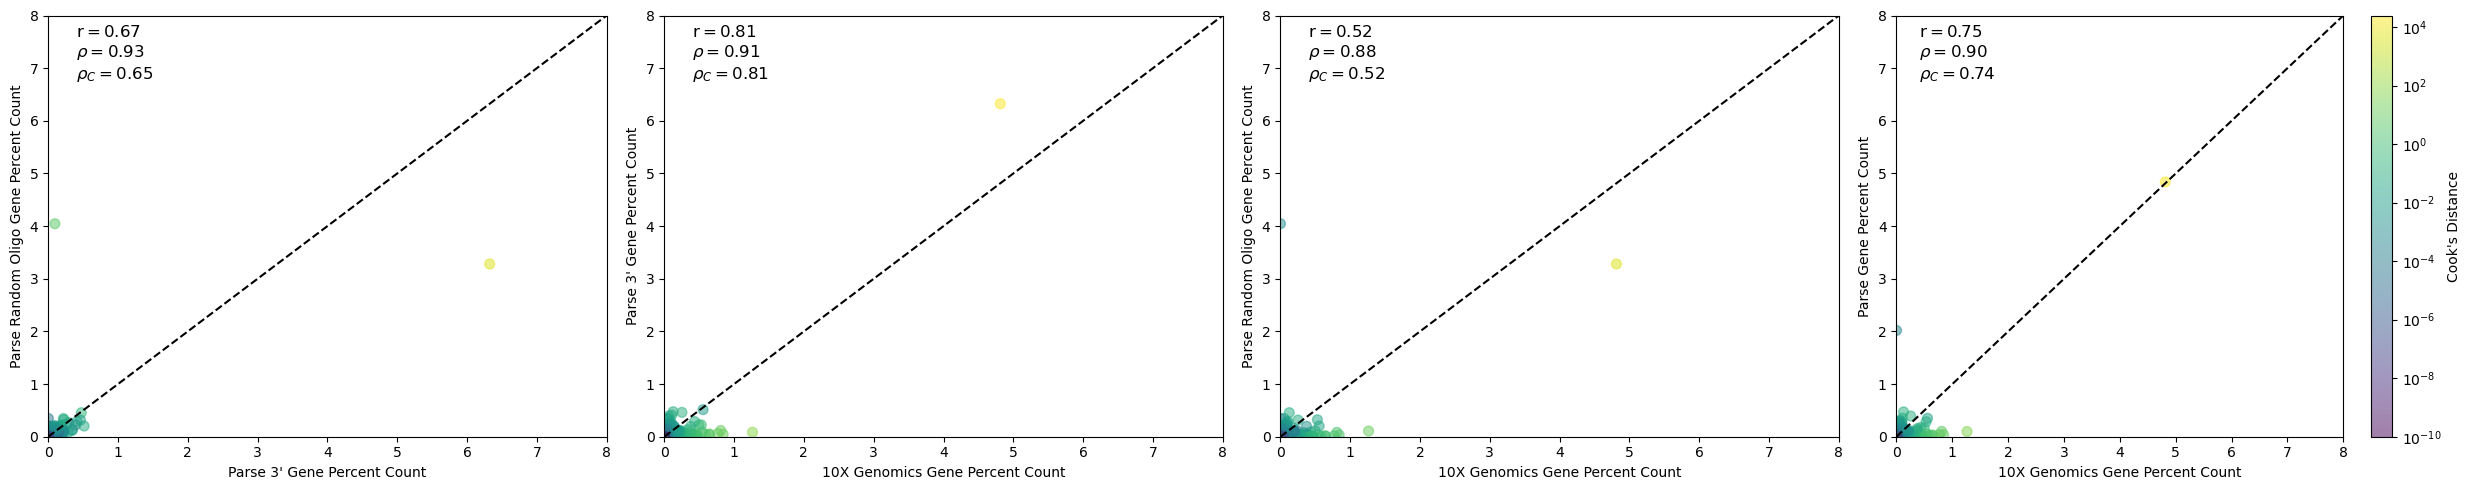

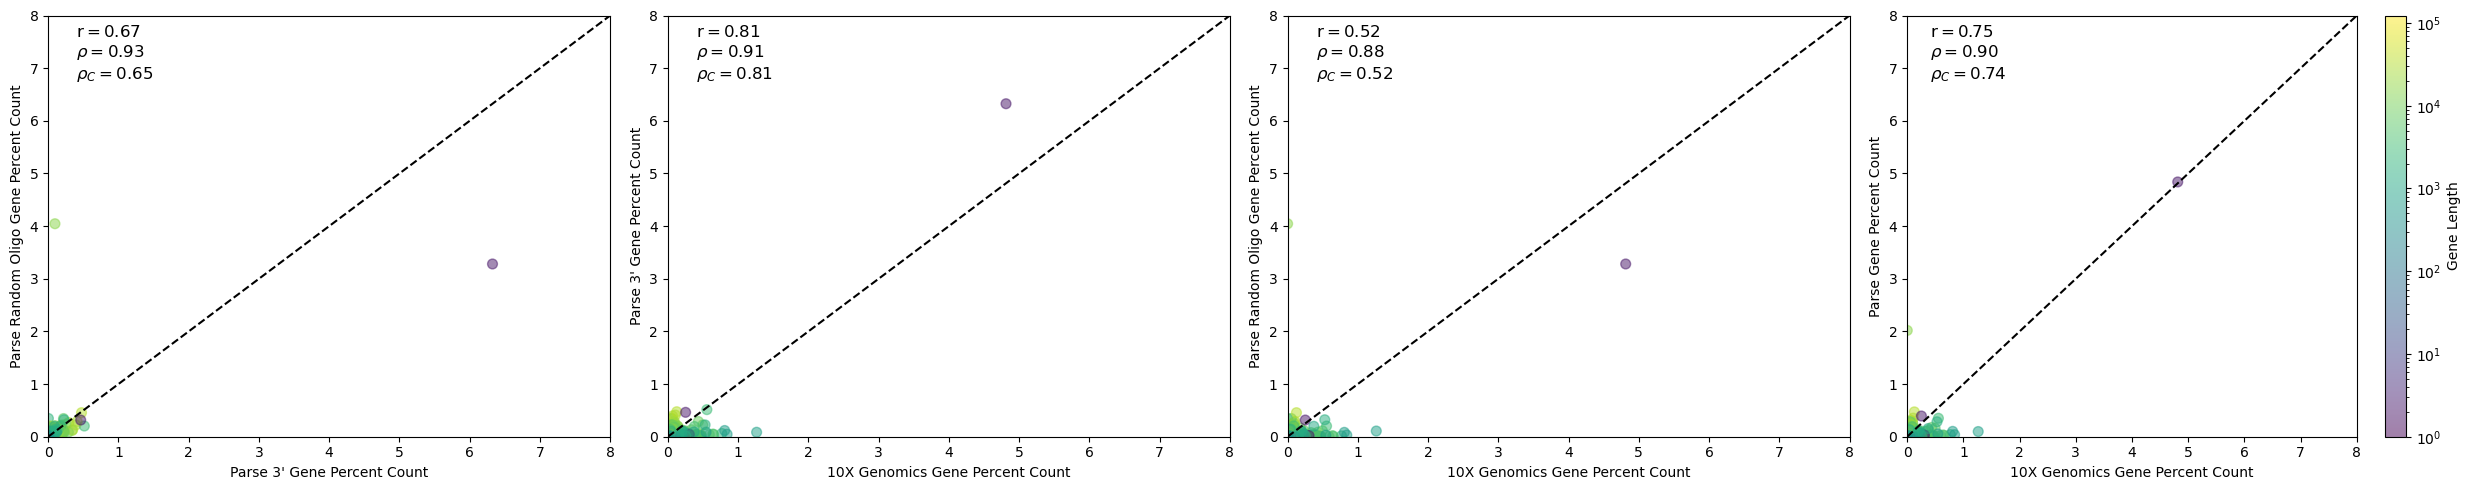

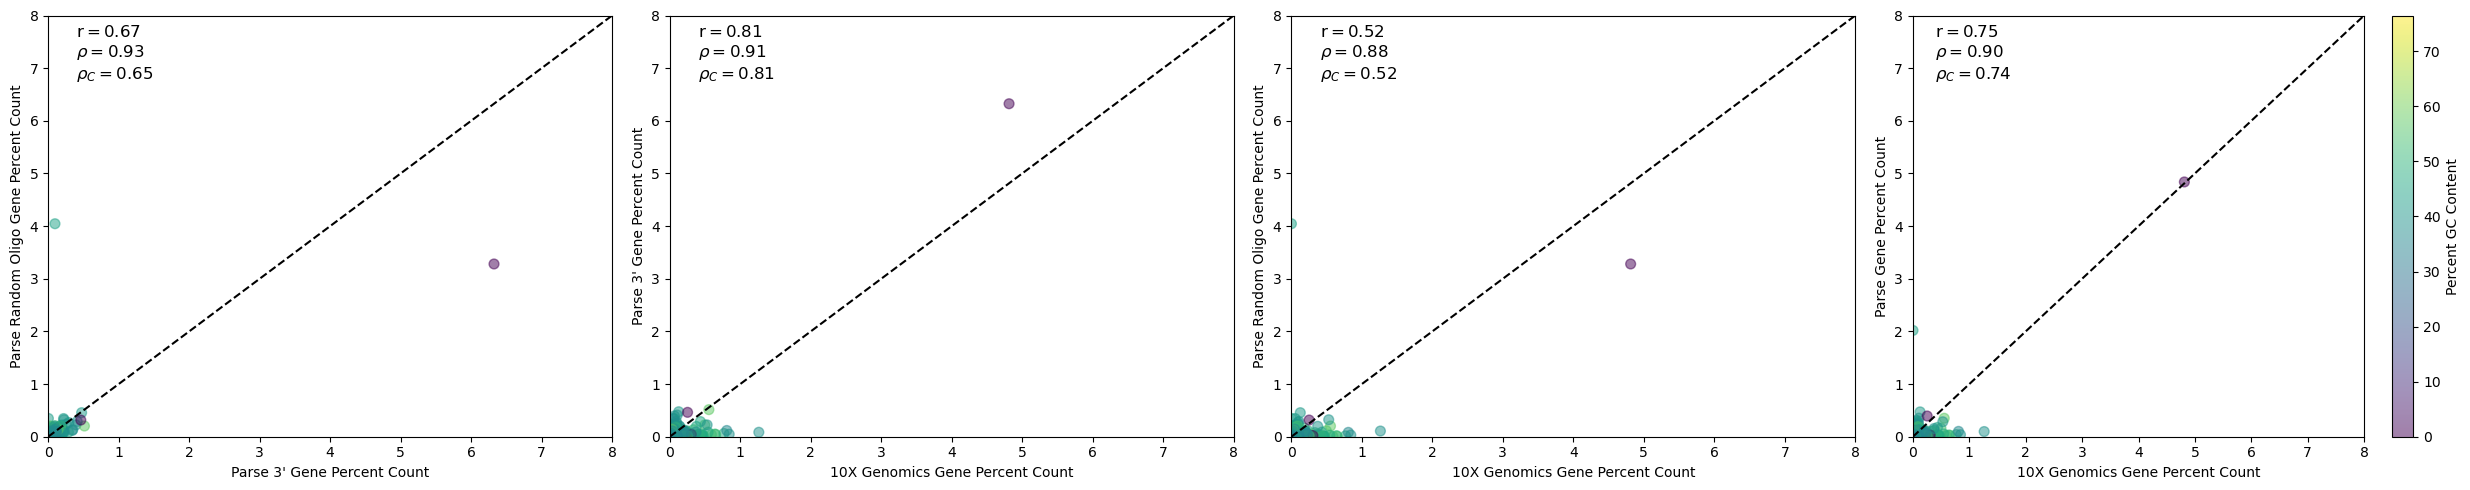

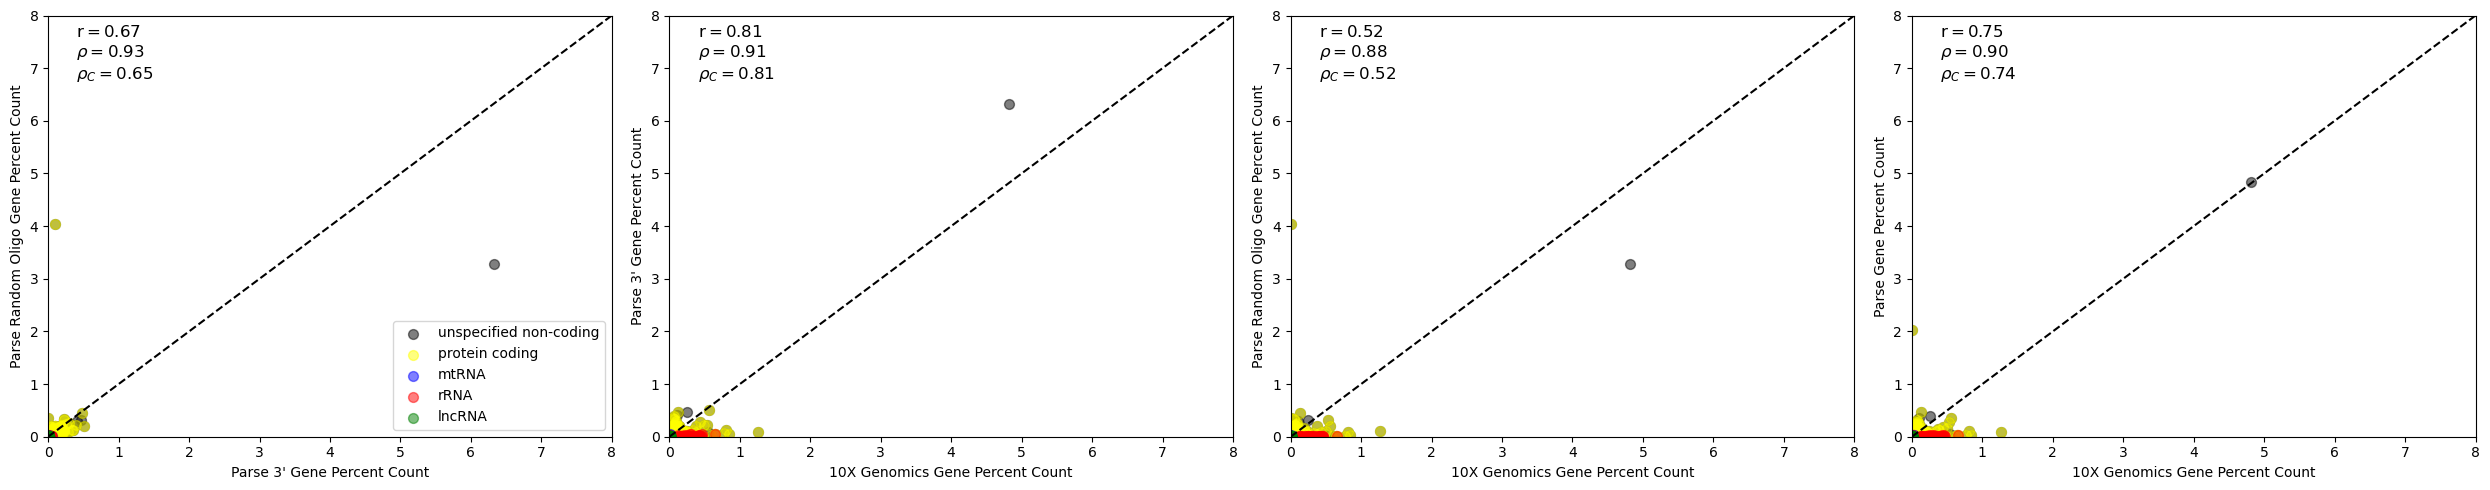

In [39]:
compare_names, compare_dfs = compare(datasets, 8)

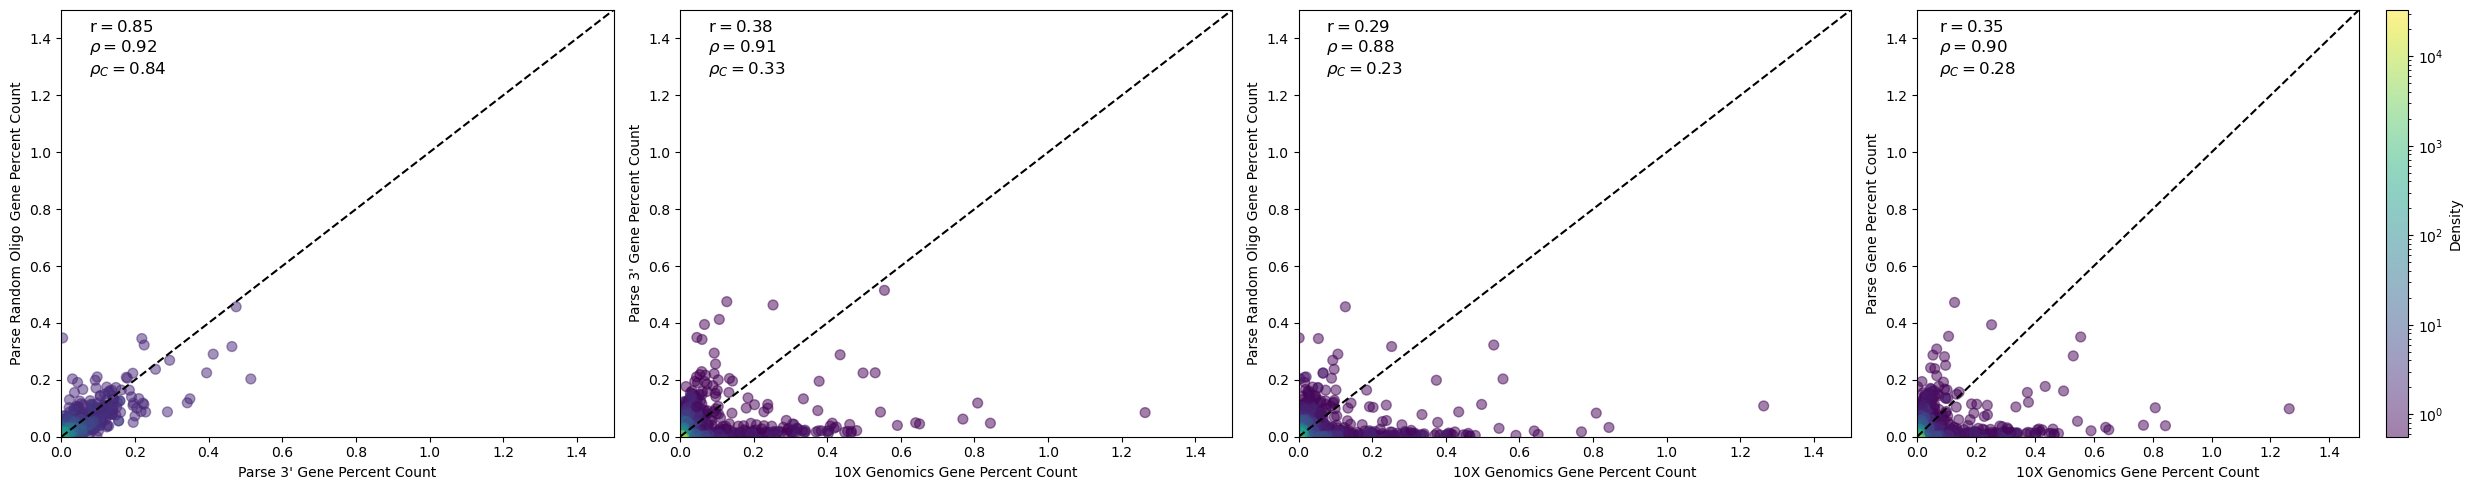

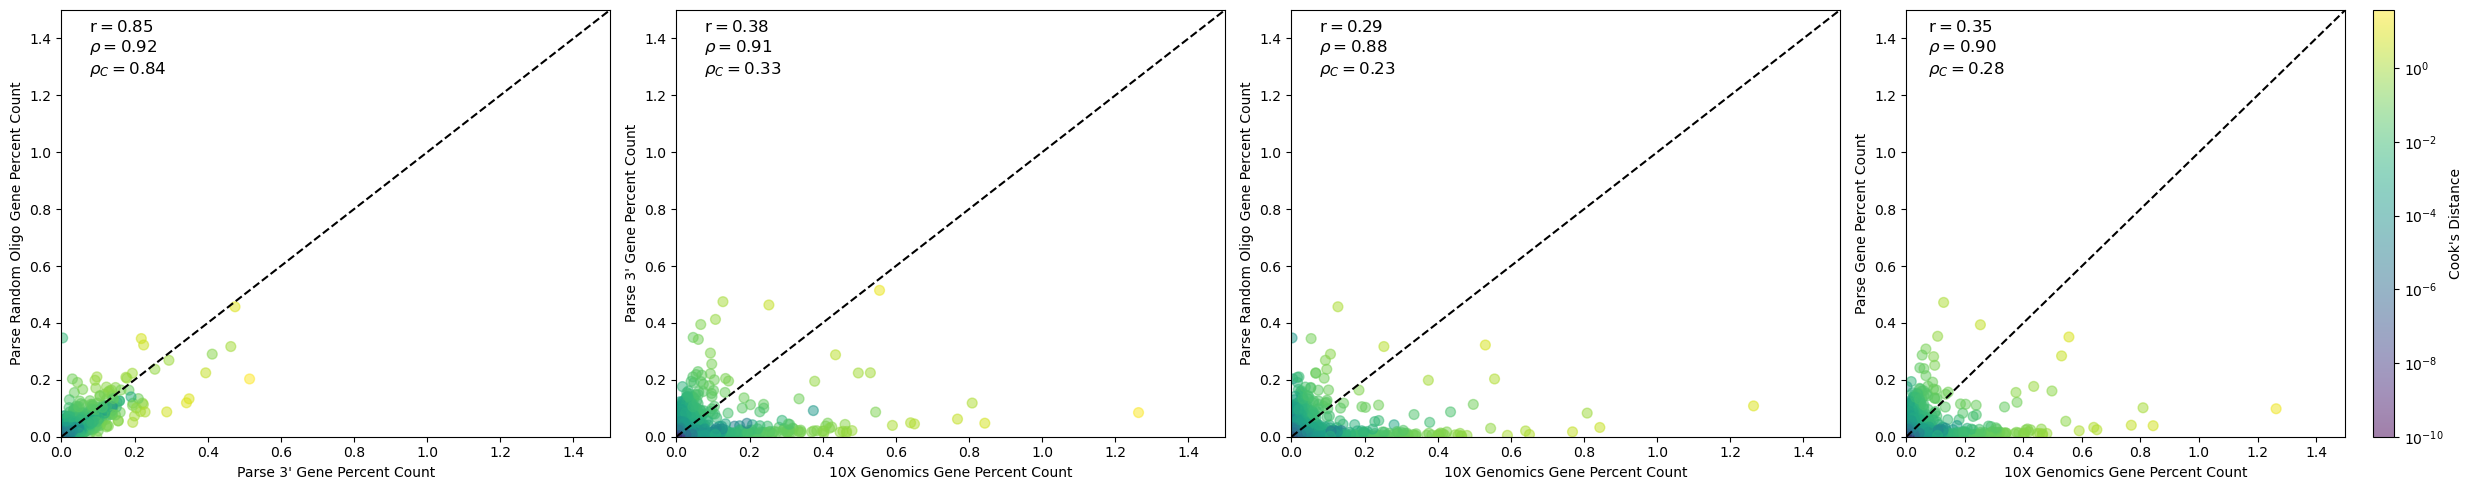

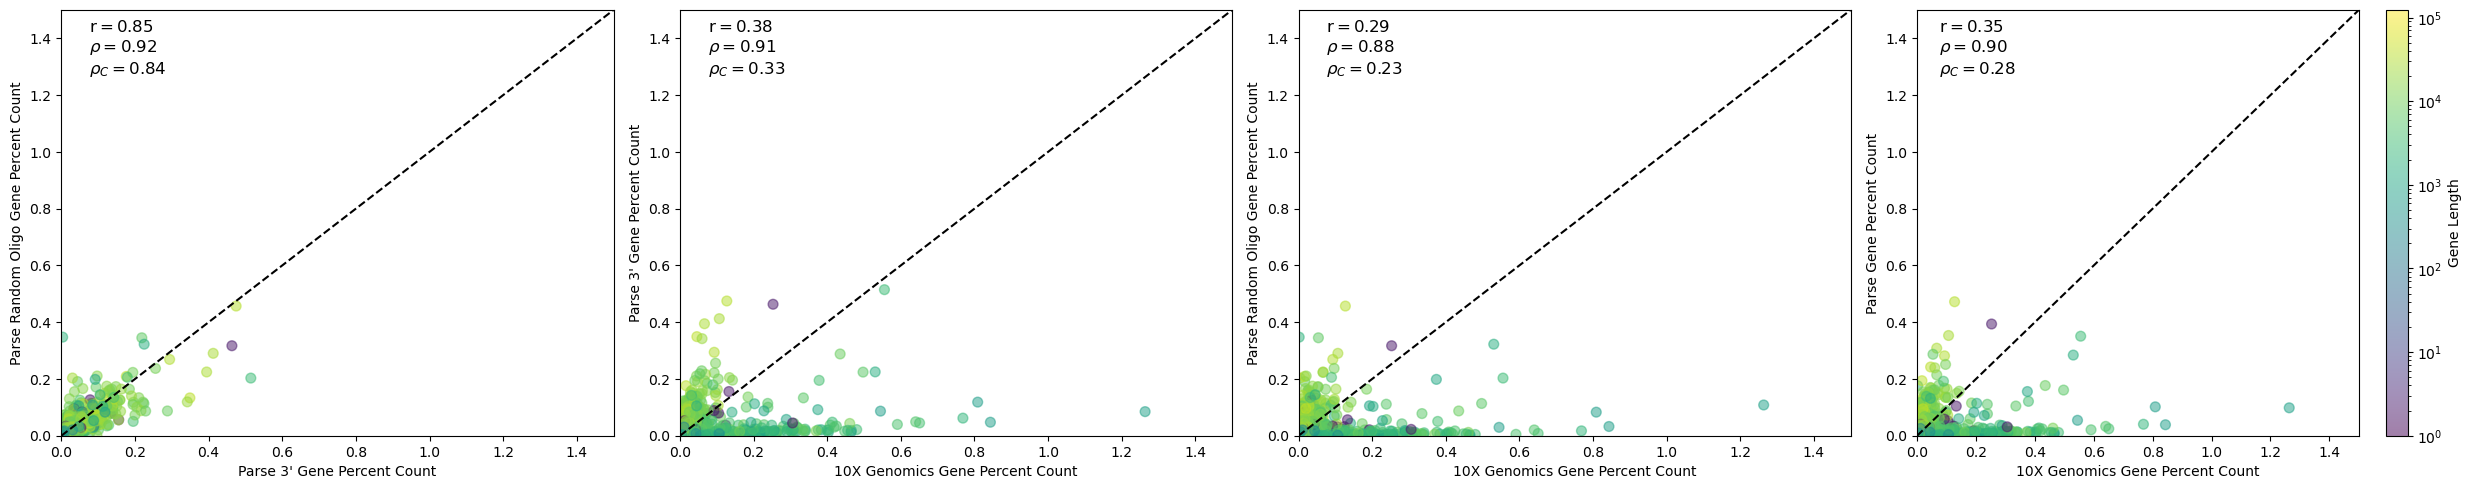

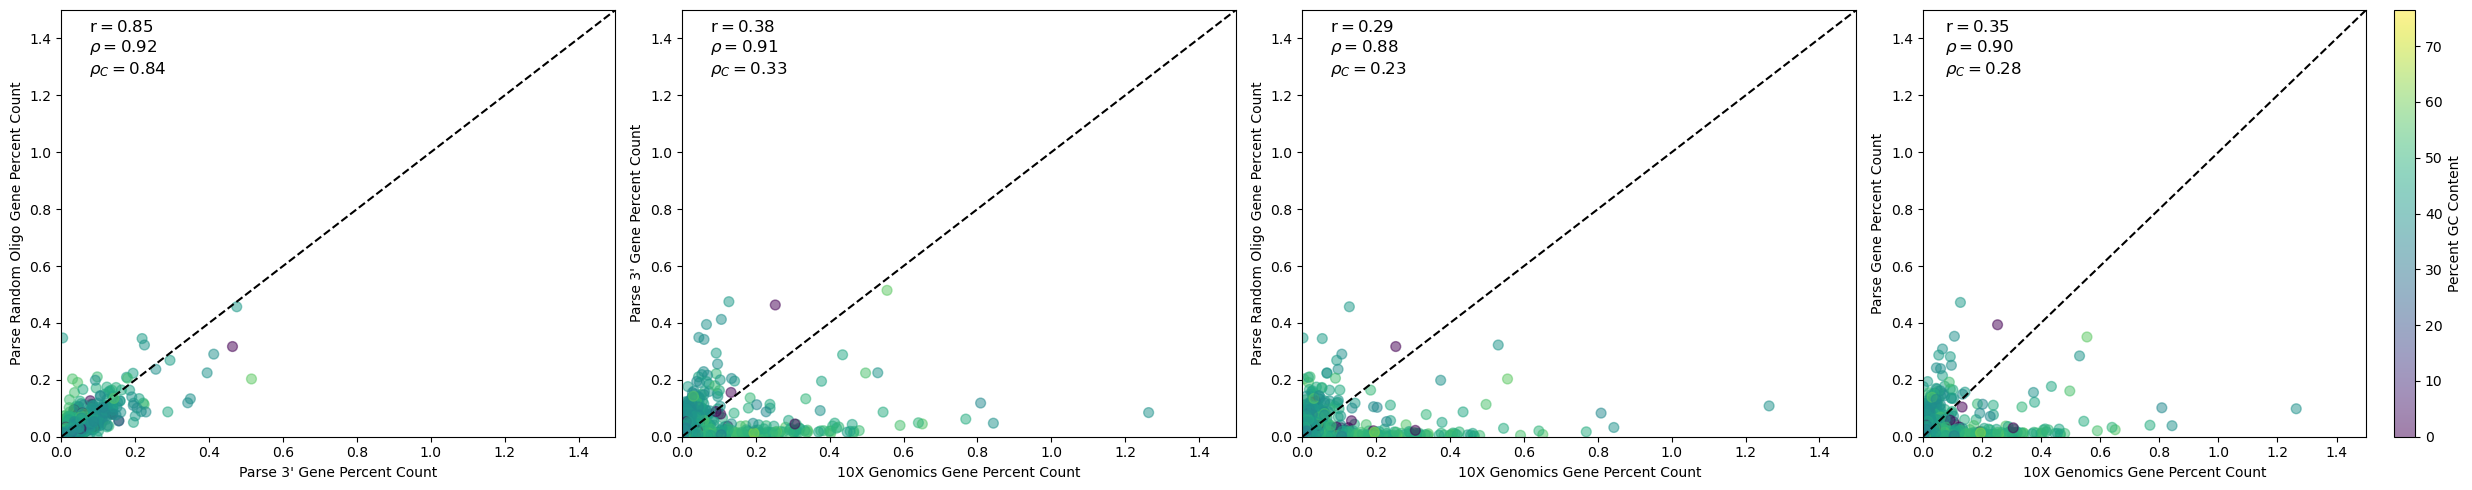

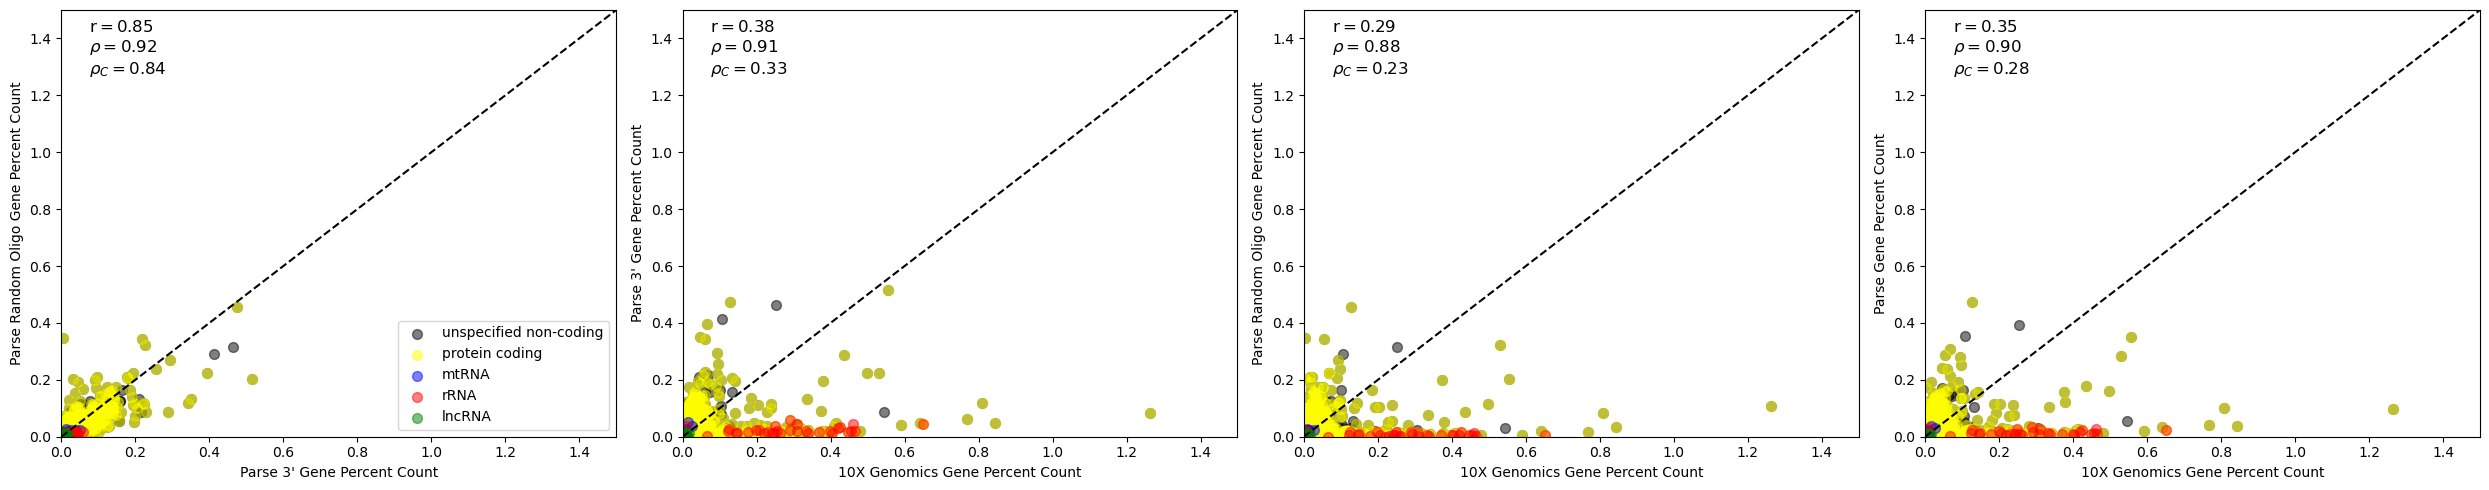

(['polyT_randO', '10x_polyT', '10x_randO', '10x_parse'],
 [           gene_name                gene_id  percent_counts_x  gene_length  \
  0      0610005C13Rik   ENSMUSG00000109644.3          0.000178          2.0   
  1      0610009B22Rik  ENSMUSG00000007777.10          0.000278        999.0   
  2      0610009E02Rik   ENSMUSG00000086714.3          0.001096          2.0   
  3      0610009L18Rik   ENSMUSG00000043644.6          0.000071          2.0   
  4      0610010K14Rik  ENSMUSG00000020831.19          0.000190       4486.0   
  ...              ...                    ...               ...          ...   
  23871         mt-Nd3   ENSMUSG00000064360.1          0.006960        349.0   
  23872         mt-Nd4   ENSMUSG00000064363.1          0.112582       1379.0   
  23873        mt-Nd4l   ENSMUSG00000065947.1          0.007712        298.0   
  23874         mt-Nd5   ENSMUSG00000064367.1          0.105166       1825.0   
  23875         mt-Nd6   ENSMUSG00000064368.1          0.004028

In [40]:
compare(datasets, 1.5)

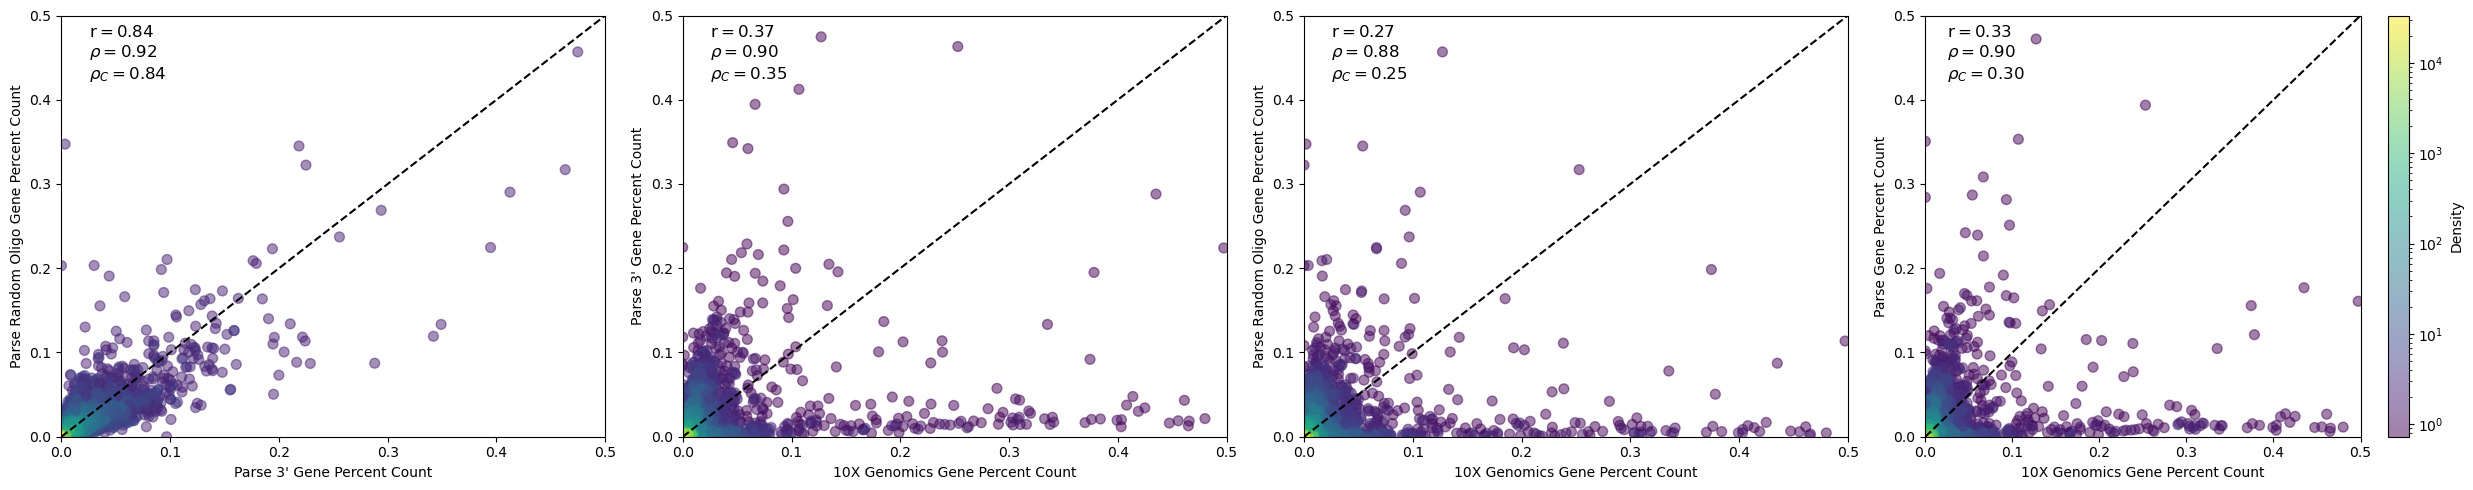

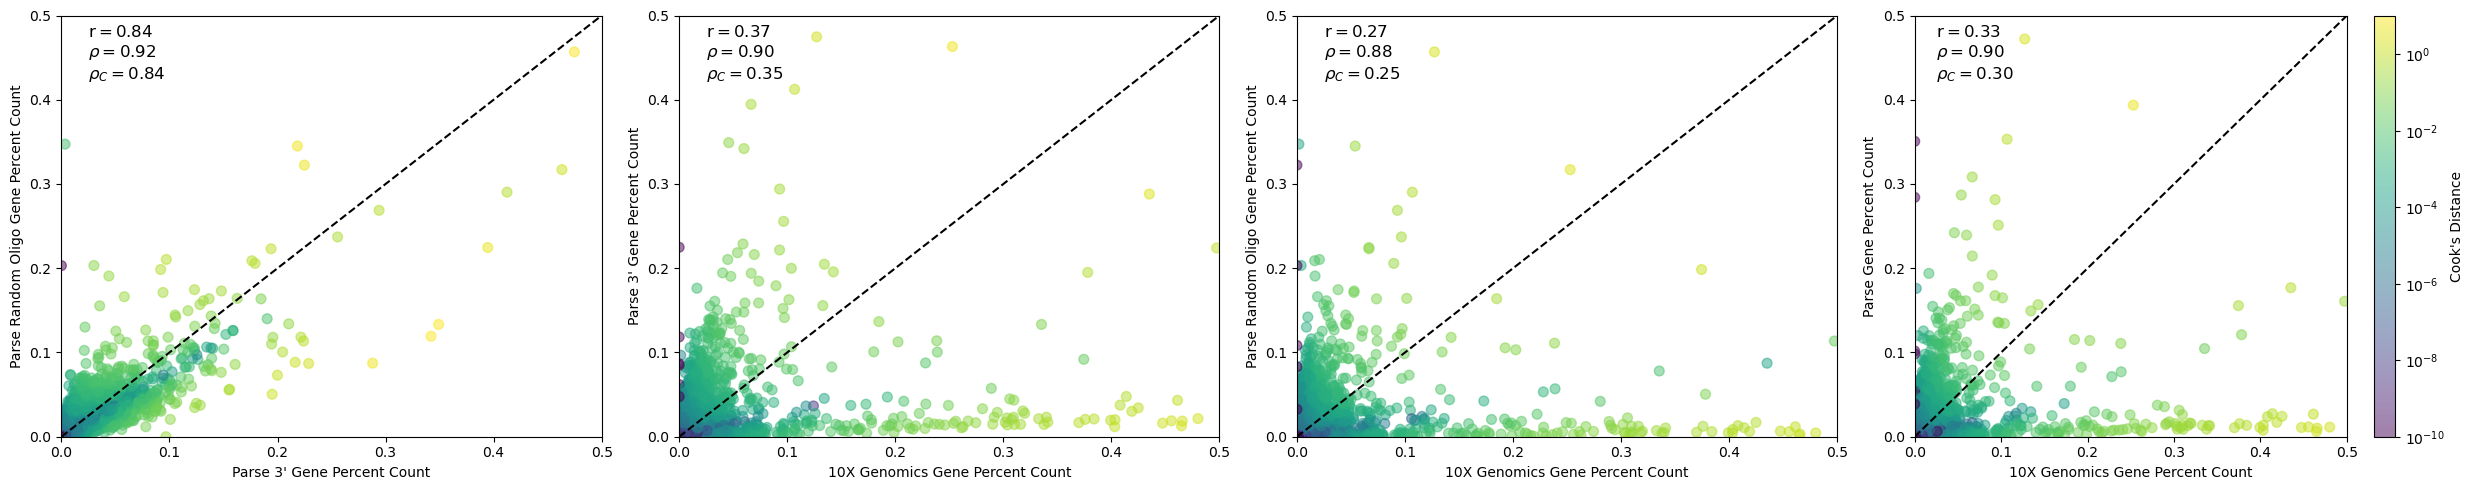

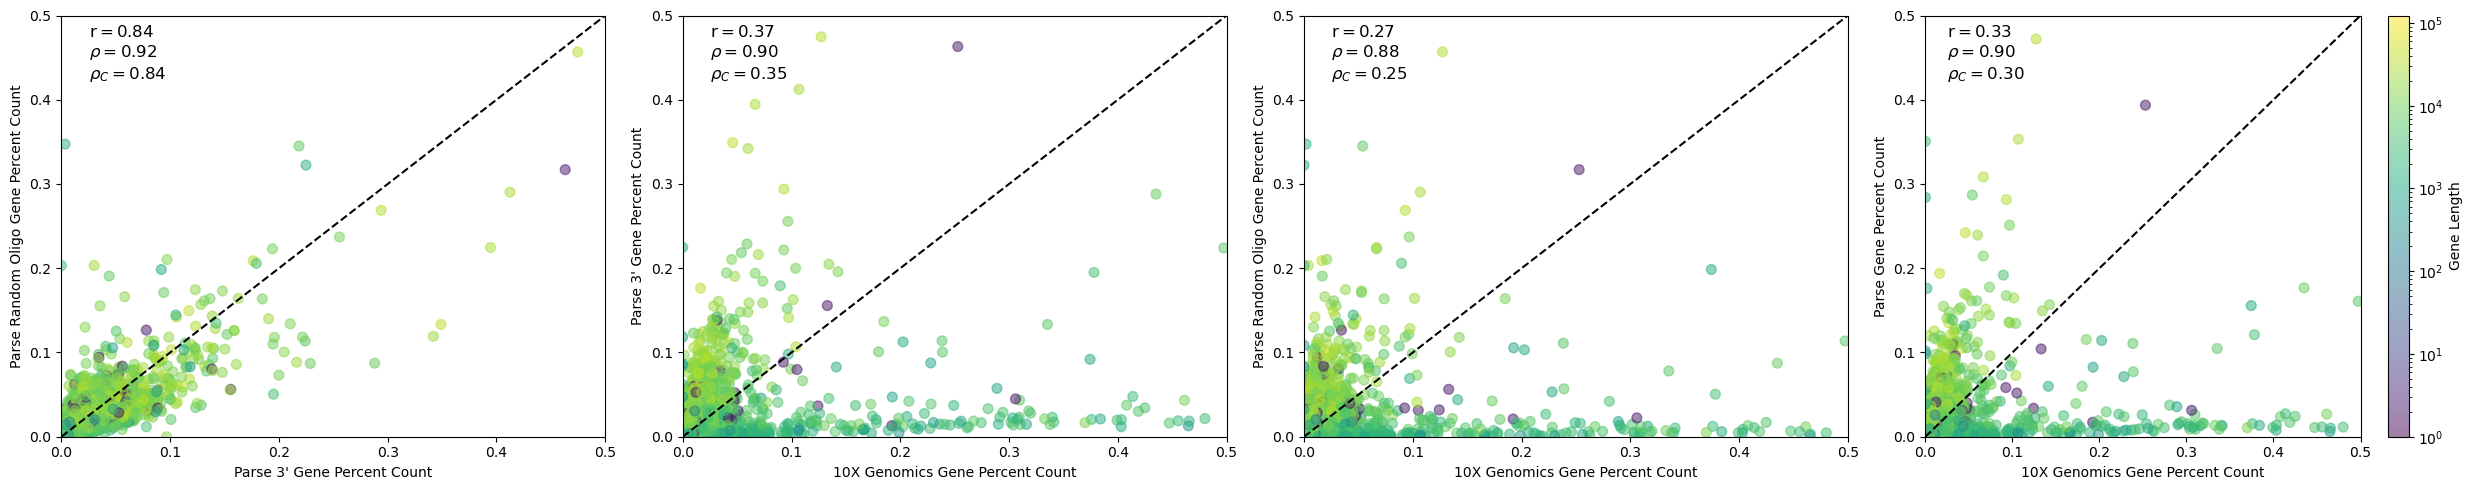

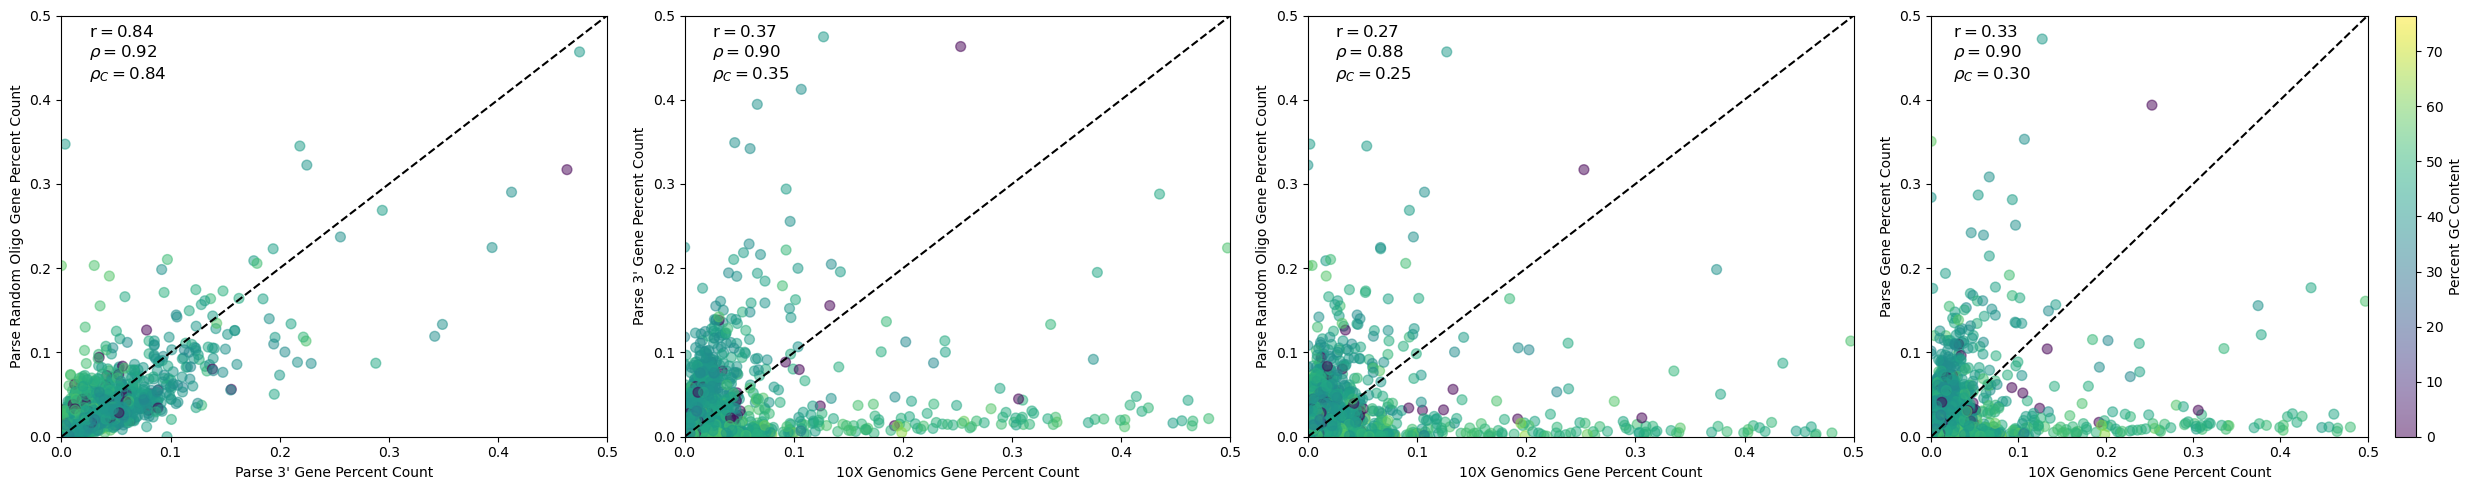

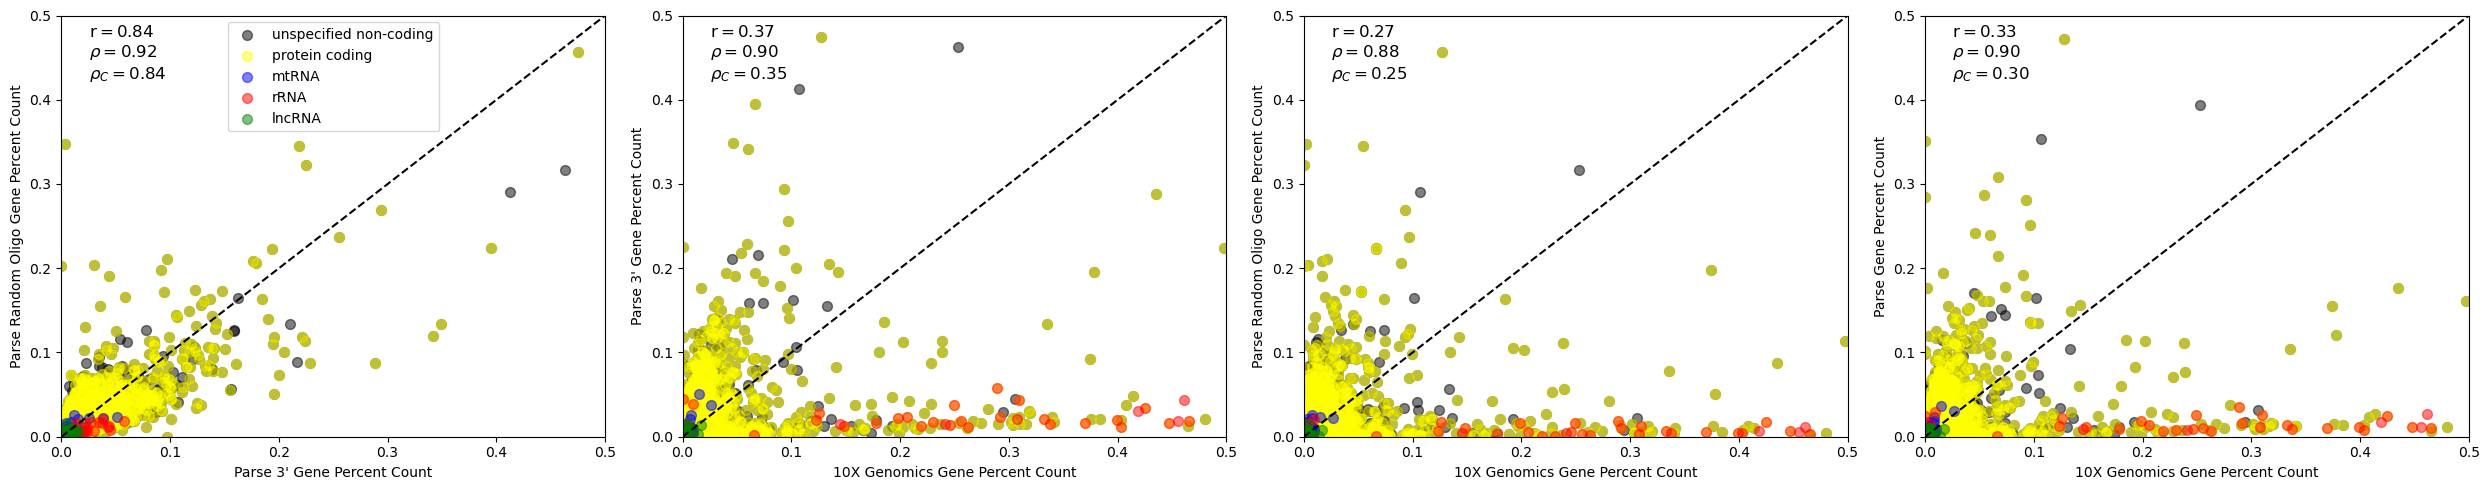

(['polyT_randO', '10x_polyT', '10x_randO', '10x_parse'],
 [           gene_name                gene_id  percent_counts_x  gene_length  \
  0      0610005C13Rik   ENSMUSG00000109644.3          0.000178          2.0   
  1      0610009B22Rik  ENSMUSG00000007777.10          0.000278        999.0   
  2      0610009E02Rik   ENSMUSG00000086714.3          0.001096          2.0   
  3      0610009L18Rik   ENSMUSG00000043644.6          0.000071          2.0   
  4      0610010K14Rik  ENSMUSG00000020831.19          0.000190       4486.0   
  ...              ...                    ...               ...          ...   
  23871         mt-Nd3   ENSMUSG00000064360.1          0.006960        349.0   
  23872         mt-Nd4   ENSMUSG00000064363.1          0.112582       1379.0   
  23873        mt-Nd4l   ENSMUSG00000065947.1          0.007712        298.0   
  23874         mt-Nd5   ENSMUSG00000064367.1          0.105166       1825.0   
  23875         mt-Nd6   ENSMUSG00000064368.1          0.004028

In [41]:
compare(datasets, 0.5)

In [42]:
def mergeByCooks(gene_info, compare_name, compare_df):
    cooks_df = compare_df[['gene_id', 'cooks_distance']]
    gene_info = gene_info.merge(cooks_df, how = 'left', on = ['gene_id'])
    gene_info = gene_info.rename(columns = {'cooks_distance': compare_name + '_distance'})
    return gene_info

for name, df in zip(compare_names, compare_dfs):
    gene_info = mergeByCooks(gene_info, name, df)

full_gene_info_path = 'gene_comparisons.csv'
gene_info.to_csv(full_gene_info_path)

In [43]:
dict = {}
cell_thresh = 10
contents = pd.DataFrame()

# Generate upset plot comparing genes expressed in each method
for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    mask = (gene_info['gene_id'].isin(var['gene_id'])).tolist()
    contents[str(data.uns['name'])] = mask

upset = Upset.generate_plot(contents)
contents['gene_ids'] = gene_info['gene_id']
upset.show()

In [44]:
# Extract gene subsets that were interesting in the upset plot

genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_PO = contents['gene_ids'][~contents['10x']& 
                                ~contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_PO = genes_PO.tolist()

genes_XPO = contents['gene_ids'][contents['10x']& 
                                ~contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_XPO = genes_XPO.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

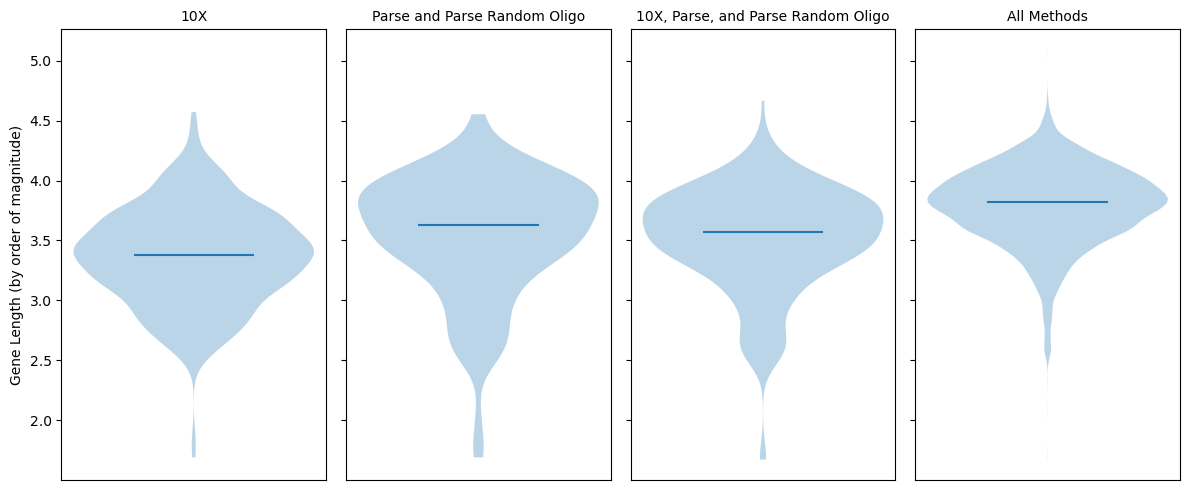

In [45]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_info[gene_info['gene_id'].isin(data)]['gene_length'].tolist()    
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

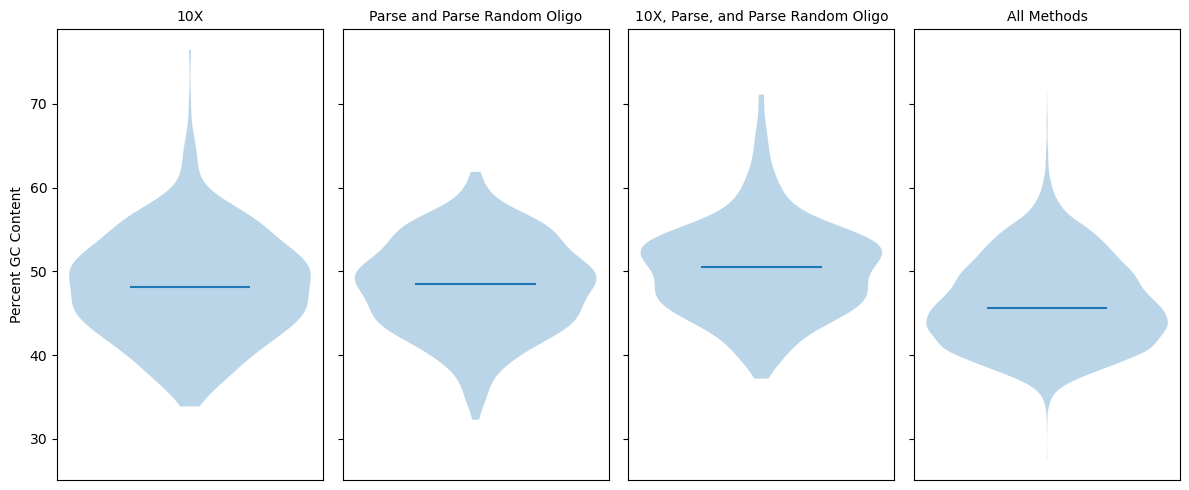

In [46]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gene_info[gene_info['gene_id'].isin(data)]['gc_content'].tolist()
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

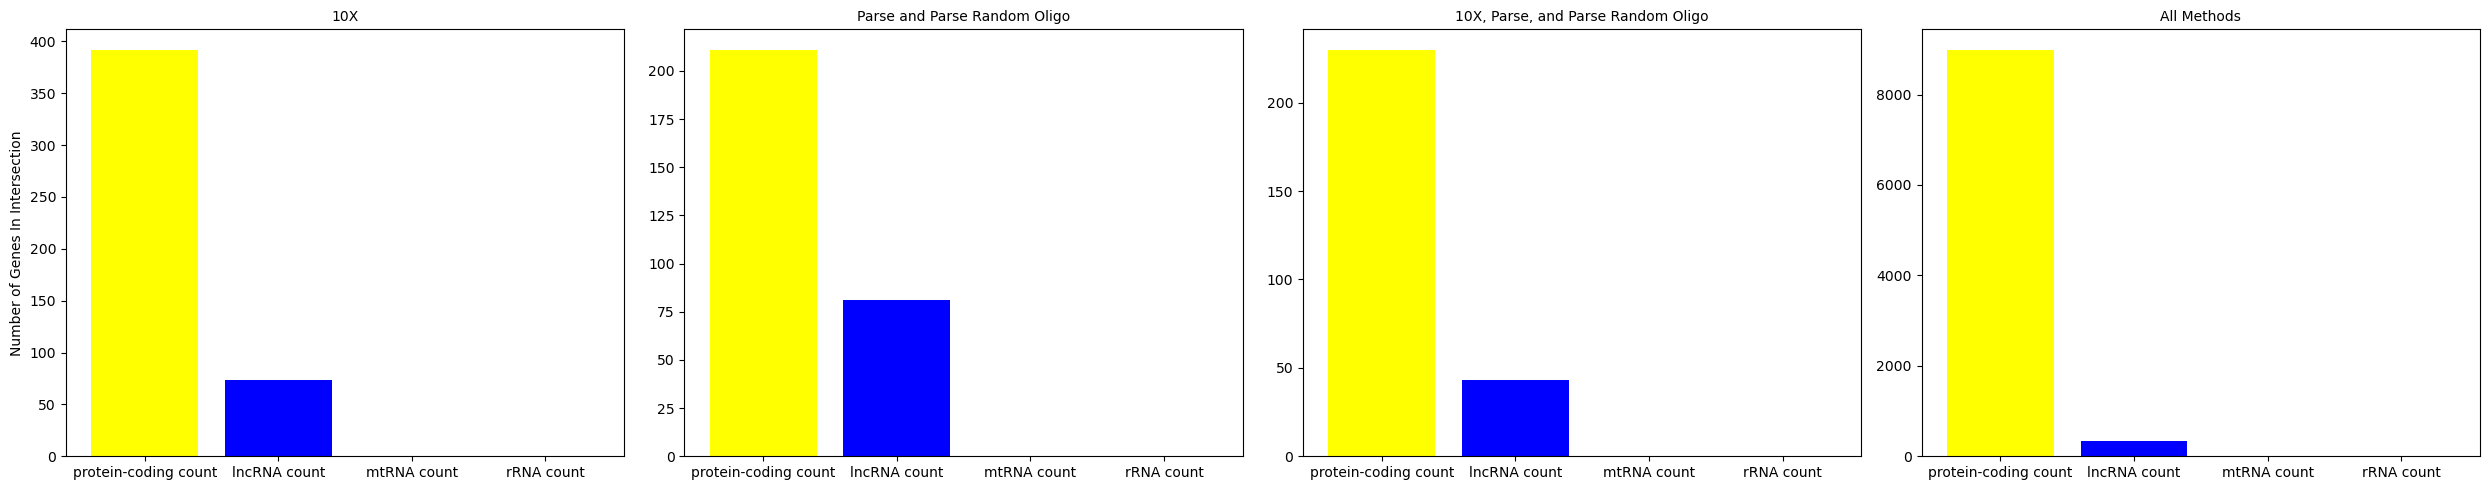

In [47]:
geneset_names = ['10X', 'Parse and Parse Random Oligo', '10X, Parse, and Parse Random Oligo', 'All Methods']
genesets = [genes_10x, genes_PO, genes_XPO, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_info[col][gene_info['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)

axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()

In [48]:
dict = {}
cell_thresh = 10

# Generate Upset plot comparing 1000 top genes expressed (by total counts) in each method
for data in datasets:
    var = data.var[data.var['n_cells']>cell_thresh]
    top_data = var.sort_values(by='percent_counts',ascending=False).head(1000)
    dict[str(data.uns['name'])] = (gene_info['gene_id'].isin(top_data['gene_id'])).tolist()
contents = pd.DataFrame(dict) 

upset = Upset.generate_plot(contents)
contents['gene_ids'] = gene_info['gene_id']
upset.show()

In [49]:
genes_10x = contents['gene_ids'][contents['10x']& 
                                 ~contents['polyT']&
                                 ~contents['randO']&
                                 ~contents['parse']]
genes_10x = genes_10x.tolist()

genes_POT = contents['gene_ids'][~contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_POT = genes_POT.tolist()

genes_all = contents['gene_ids'][contents['10x']& 
                                contents['polyT']&
                                contents['randO']&
                                contents['parse']]
genes_all = genes_all.tolist()

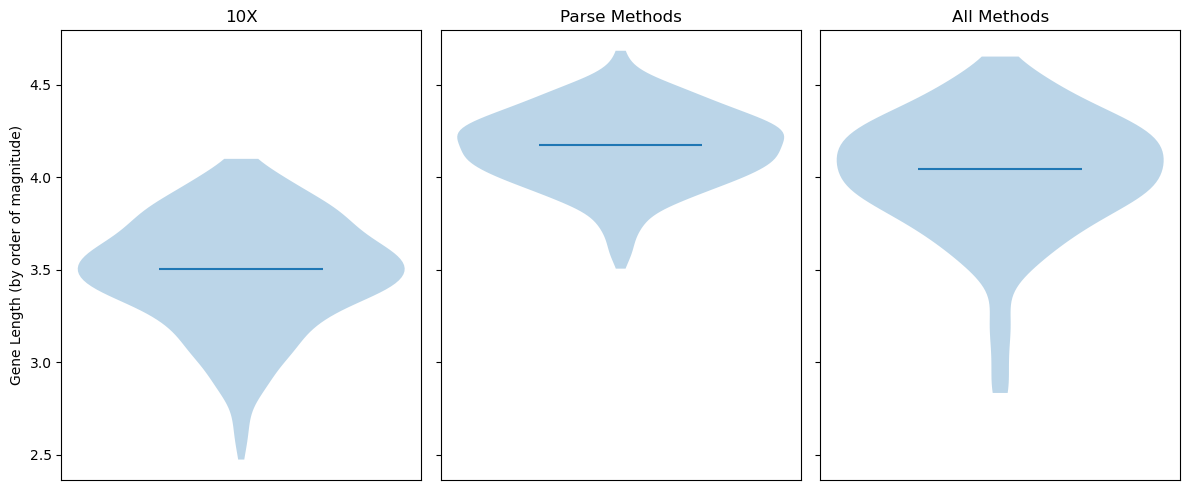

In [50]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    lengths = gene_info[gene_info['gene_id'].isin(data)]['gene_length'].tolist()
    ax.violinplot(np.log10(lengths),showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Gene Length (by order of magnitude)')


plt.tight_layout()
plt.show()

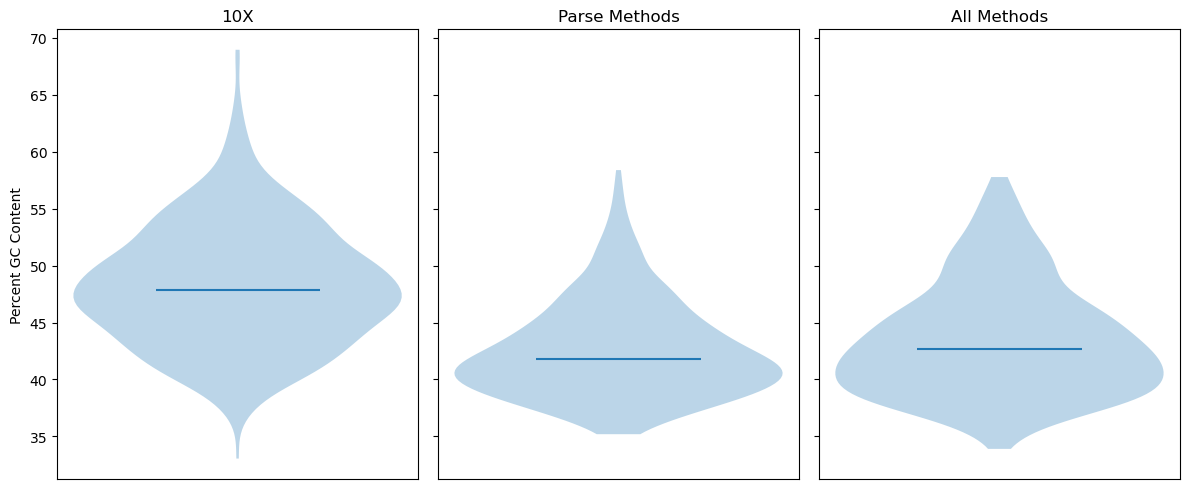

In [51]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]

fig, axs = plt.subplots(1, len(genesets), figsize=(12,5), sharey='row')
for ax, data, name in zip(axs, genesets, geneset_names):
    gcs = gene_info[gene_info['gene_id'].isin(data)]['gc_content'].tolist()
    ax.violinplot(gcs,showextrema=False, showmedians=True)
    ax.set_title(name)
    ax.set_xticks([])

axs[0].set_ylabel('Percent GC Content')


plt.tight_layout()
plt.show()

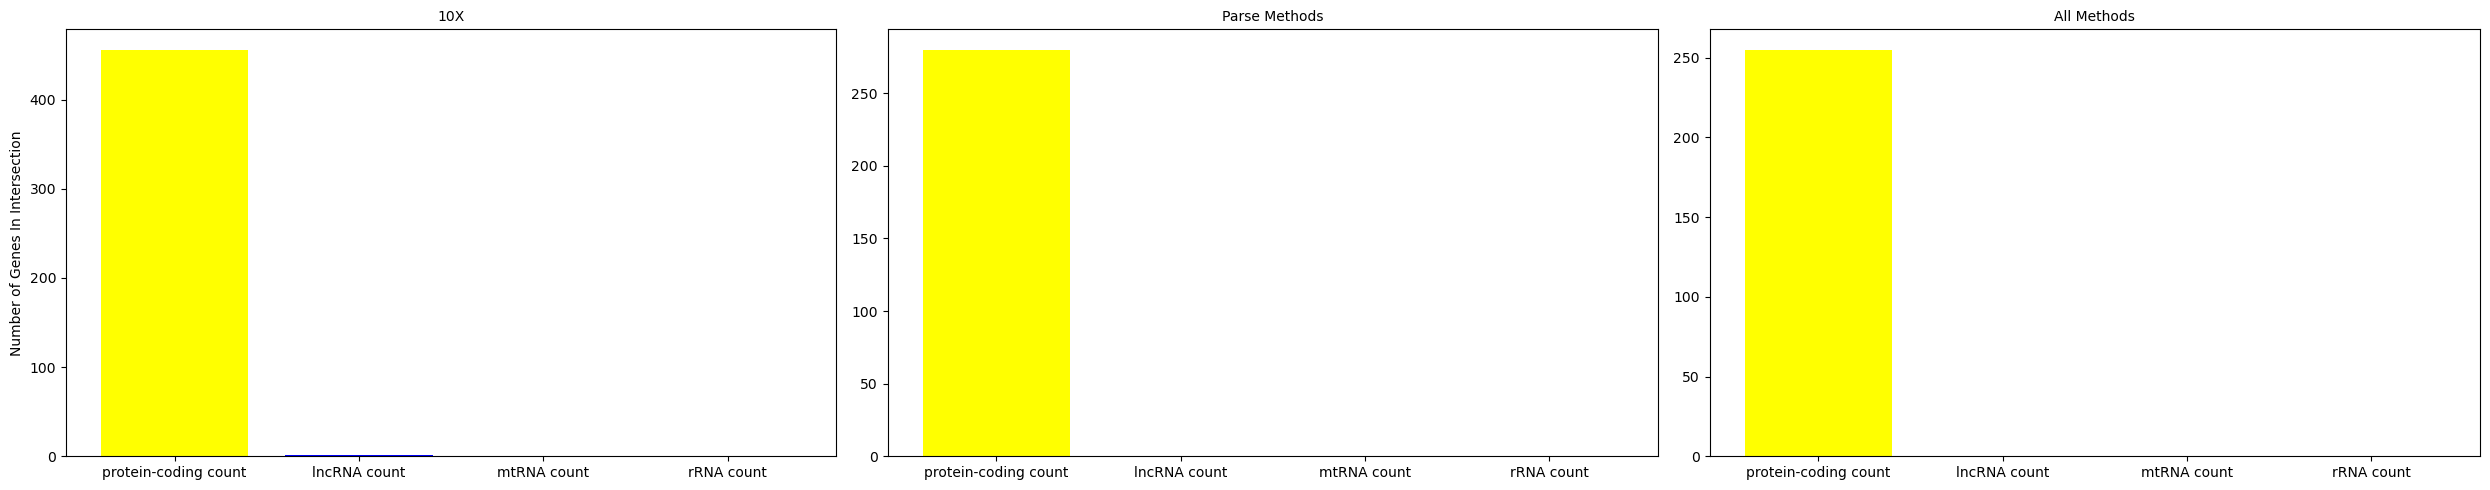

In [52]:
geneset_names = ['10X', 'Parse Methods', 'All Methods']
genesets = [genes_10x, genes_POT, genes_all]
cols = ['is_pc', 'is_lnc', 'is_mito', 'is_ribo']
col_names = ['protein-coding count', 'lncRNA count', 'mtRNA count', 'rRNA count']
color = ['yellow', 'blue', 'red', 'green']

fig, axs = plt.subplots(1, len(genesets), figsize=(25,5))
for ax, data, name in zip(axs, genesets, geneset_names):
    sums = []
    for col in cols:
        sums.append(gene_info[col][gene_info['gene_id'].isin(data)].sum())
    ax.bar(col_names,sums,color=color)
    ax.set_title(name, fontsize=10)
axs[0].set_ylabel('Number of Genes In Intersection')


plt.tight_layout()
plt.show()